<a href="https://colab.research.google.com/github/nazimurahman/market-basket-analysis/blob/main/market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis")

Skipping, found downloaded files in "./market-basket-analysis" (use force=True to force download)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Load the dataset
file_path = "/content/market-basket-analysis/Assignment-1_Data.xlsx"
df = pd.read_excel(file_path)
df.head() # showing some data

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"Number of transactions: {df['BillNo'].nunique()}")
print(f"Number of unique products: {df['Itemname'].nunique()}")
print(f"Number of unique customers: {df['CustomerID'].nunique()}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Dataset shape: (522064, 7)
Number of transactions: 21663
Number of unique products: 4185
Number of unique customers: 4297
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      522064 non-null  object        
 1   Itemname    520609 non-null  object        
 2   Quantity    522064 non-null  int64         
 3   Date        522064 non-null  datetime64[ns]
 4   Price       522064 non-null  float64       
 5   CustomerID  388023 non-null  float64       
 6   Country     522064 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 27.9+ MB


In [ ]:
# Discriptive analysis of the Data
df.describe(include= 'all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
BillNo,522064.0,21663.0,573585.0,1114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Itemname,520609,4185,WHITE HANGING HEART T-LIGHT HOLDER,2269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,522064.0,NaN,NaN,NaN,10.090435,-9600.0,1.0,3.0,10.0,80995.0,161.110525
Date,522064,NaN,NaN,NaN,2011-07-04 12:51:20.777107456,2010-12-01 08:26:00,2011-03-28 10:15:00,2011-07-20 08:59:00,2011-10-19 14:12:00,2011-12-09 12:50:00,NaN
Price,522064.0,NaN,NaN,NaN,3.826801,-11062.06,1.25,2.08,4.13,13541.33,41.900599
CustomerID,388023.0,NaN,NaN,NaN,15316.93171,12346.0,13950.0,15265.0,16837.0,18287.0,1721.846964
Country,522064,30,United Kingdom,487622,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Statistical Analysis of selected columns
df[['Quantity', 'Price']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,522064.0,10.090435,161.110525,-9600.00,1.00,3.00,10.00,80995.00
Price,522064.0,3.826801,41.900599,-11062.06,1.25,2.08,4.13,13541.33


In [ ]:
# Check missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
for col in df.columns:
    print(f"{col}: {missing_data[col]} ({missing_percent[col]:.2f}%)")

# Remove rows with critical missing values
initial_shape = df.shape[0]
df = df.dropna(subset=['BillNo', 'Itemname'])
print(f"Removed {initial_shape - df.shape[0]} rows with missing critical data")

BillNo: 0 (0.00%)
Itemname: 1455 (0.28%)
Quantity: 0 (0.00%)
Date: 0 (0.00%)
Price: 0 (0.00%)
CustomerID: 134041 (25.68%)
Country: 0 (0.00%)
Removed 1455 rows with missing critical data


In [ ]:
# Check for negative quantities and prices
negative_quantities = df[df['Quantity'] < 0]
negative_prices = df[df['Price'] < 0]

print(f"Transactions with negative quantities: {len(negative_quantities)}")
print(f"Transactions with negative prices: {len(negative_prices)}")

Transactions with negative quantities: 473
Transactions with negative prices: 2


In [ ]:
# Remove negative quantities and prices
df = df[df['Quantity'] > 0]
df = df[df['Price'] >= 0]
print(f"Data shape after cleaning: {df.shape}")

Data shape after cleaning: (520134, 7)


In [ ]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour

In [ ]:
# Transaction volume over time
daily_transactions = df.groupby(df['Date'].dt.date)['BillNo'].nunique()
monthly_transactions = df.groupby(['Year', 'Month'])['BillNo'].nunique()

print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Average daily transactions: {daily_transactions.mean():.2f}")
print(f"Peak daily transactions: {daily_transactions.max()}")
print(f"Total number of days: {len(daily_transactions)}")

Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Average daily transactions: 64.70
Peak daily transactions: 141
Total number of days: 305


In [ ]:
customer_transactions = df.groupby('CustomerID')['BillNo'].nunique()
customer_spend = df.groupby('CustomerID')['Price'].sum()

print(f"Total unique customers: {len(customer_transactions)}")
print(f"Average transactions per customer: {customer_transactions.mean():.2f}")
print(f"Median transactions per customer: {customer_transactions.median():.2f}")
print(f"Top 10% customers by transactions: {customer_transactions.quantile(0.9):.2f}")
print(f"Average spend per customer: ${customer_spend.mean():.2f}")
print(f"Top 10% customers by spend: ${customer_spend.quantile(0.9):.2f}")

Total unique customers: 4297
Average transactions per customer: 4.23
Median transactions per customer: 2.00
Top 10% customers by transactions: 9.00
Average spend per customer: $278.06
Top 10% customers by spend: $632.02


In [ ]:
product_popularity = df['Itemname'].value_counts()
product_revenue = df.groupby('Itemname')['Price'].sum().sort_values(ascending=False)
product_quantity = df.groupby('Itemname')['Quantity'].sum().sort_values(ascending=False)

print(f"Most popular product: {product_popularity.index[0]} ({product_popularity.iloc[0]} times)")
print(f"Top 10 products account for {product_popularity.head(10).sum()/len(df)*100:.2f}% of transactions")
print(f"Highest revenue product: {product_revenue.index[0]} (${product_revenue.iloc[0]:.2f})")
print(f"Highest quantity product: {product_quantity.index[0]} ({product_quantity.iloc[0]} units)")

Most popular product: WHITE HANGING HEART T-LIGHT HOLDER (2269 times)
Top 10 products account for 3.12% of transactions
Highest revenue product: DOTCOM POSTAGE ($206248.77)
Highest quantity product: PAPER CRAFT , LITTLE BIRDIE (80995 units)


In [ ]:
# Price analysis
print(f"\nPrice Statistics:")
print(f"Average price: ${df['Price'].mean():.2f}")
print(f"Median price: ${df['Price'].median():.2f}")
print(f"Maximum price: ${df['Price'].max():.2f}")
print(f"Minimum price: ${df['Price'].min():.2f}")


Price Statistics:
Average price: $3.88
Median price: $2.08
Maximum price: $13541.33
Minimum price: $0.00


In [ ]:
# Basket size analysis
basket_sizes = df.groupby('BillNo')['Itemname'].count()
print(f"\nBasket Size Analysis:")
print(f"Average items per transaction: {basket_sizes.mean():.2f}")
print(f"Maximum items in one transaction: {basket_sizes.max()}")
print(f"Transactions with single item: {(basket_sizes == 1).sum()}")


Basket Size Analysis:
Average items per transaction: 26.36
Maximum items in one transaction: 1114
Transactions with single item: 1749


In [ ]:
# Country Analysis
country_counts = df['Country'].value_counts()
country_percentage = (df['Country'].value_counts(normalize=True) * 100).round(2)

In [ ]:
# Top 10 countries by transaction volume
for country, count, perc in zip(country_counts.head(10).index,
                               country_counts.head(10).values,
                               country_percentage.head(10).values):
    print(f"  {country}: {count} transactions ({perc}%)")

  United Kingdom: 485692 transactions (93.38%)
  Germany: 9042 transactions (1.74%)
  France: 8408 transactions (1.62%)
  Spain: 2485 transactions (0.48%)
  Netherlands: 2363 transactions (0.45%)
  Belgium: 2031 transactions (0.39%)
  Switzerland: 1967 transactions (0.38%)
  Portugal: 1501 transactions (0.29%)
  Australia: 1185 transactions (0.23%)
  Norway: 1072 transactions (0.21%)


In [ ]:
# Customer Analysis
print(f"Total unique customers: {df['CustomerID'].nunique()}")
print(f"Transactions with missing CustomerID: {df['CustomerID'].isnull().sum()}")

Total unique customers: 4297
Transactions with missing CustomerID: 132111


In [ ]:
# Customer transaction frequency and statistics
customer_transactions = df.groupby('CustomerID')['BillNo'].nunique()
print(f"Average transactions per customer: {customer_transactions.mean():.2f}")
print(f"Max transactions by a single customer: {customer_transactions.max()}")
print(f"Min transactions by a single customer: {customer_transactions.min()}")

Average transactions per customer: 4.23
Max transactions by a single customer: 210
Min transactions by a single customer: 1


In [ ]:
# Product Analysis
print(f"Total unique products: {df['Itemname'].nunique()}")

Total unique products: 4056


In [ ]:
# Top products by frequency
top_products = df['Itemname'].value_counts().head(20)
# Top 20 products by frequency
for product, count in top_products.items():
    print(f"  {product}: {count} transactions")

  WHITE HANGING HEART T-LIGHT HOLDER: 2269 transactions
  JUMBO BAG RED RETROSPOT: 2087 transactions
  REGENCY CAKESTAND 3 TIER: 1930 transactions
  PARTY BUNTING: 1677 transactions
  LUNCH BAG RED RETROSPOT: 1570 transactions
  ASSORTED COLOUR BIRD ORNAMENT: 1465 transactions
  SET OF 3 CAKE TINS PANTRY DESIGN: 1360 transactions
  PACK OF 72 RETROSPOT CAKE CASES: 1328 transactions
  LUNCH BAG  BLACK SKULL.: 1315 transactions
  NATURAL SLATE HEART CHALKBOARD: 1246 transactions
  JUMBO BAG PINK POLKADOT: 1231 transactions
  HEART OF WICKER SMALL: 1206 transactions
  JUMBO STORAGE BAG SUKI: 1191 transactions
  PAPER CHAIN KIT 50'S CHRISTMAS: 1183 transactions
  JUMBO SHOPPER VINTAGE RED PAISLEY: 1181 transactions
  LUNCH BAG SPACEBOY DESIGN: 1169 transactions
  LUNCH BAG CARS BLUE: 1156 transactions
  SPOTTY BUNTING: 1133 transactions
  JAM MAKING SET PRINTED: 1123 transactions
  LUNCH BAG SUKI DESIGN: 1112 transactions


In [ ]:
# Price statistics analysis
print(f"Average price: ${df['Price'].mean():.2f}")
print(f"Most expensive item: ${df['Price'].max():.2f}")
print(f"Cheapest item: ${df['Price'].min():.2f}")

Average price: $3.88
Most expensive item: $13541.33
Cheapest item: $0.00


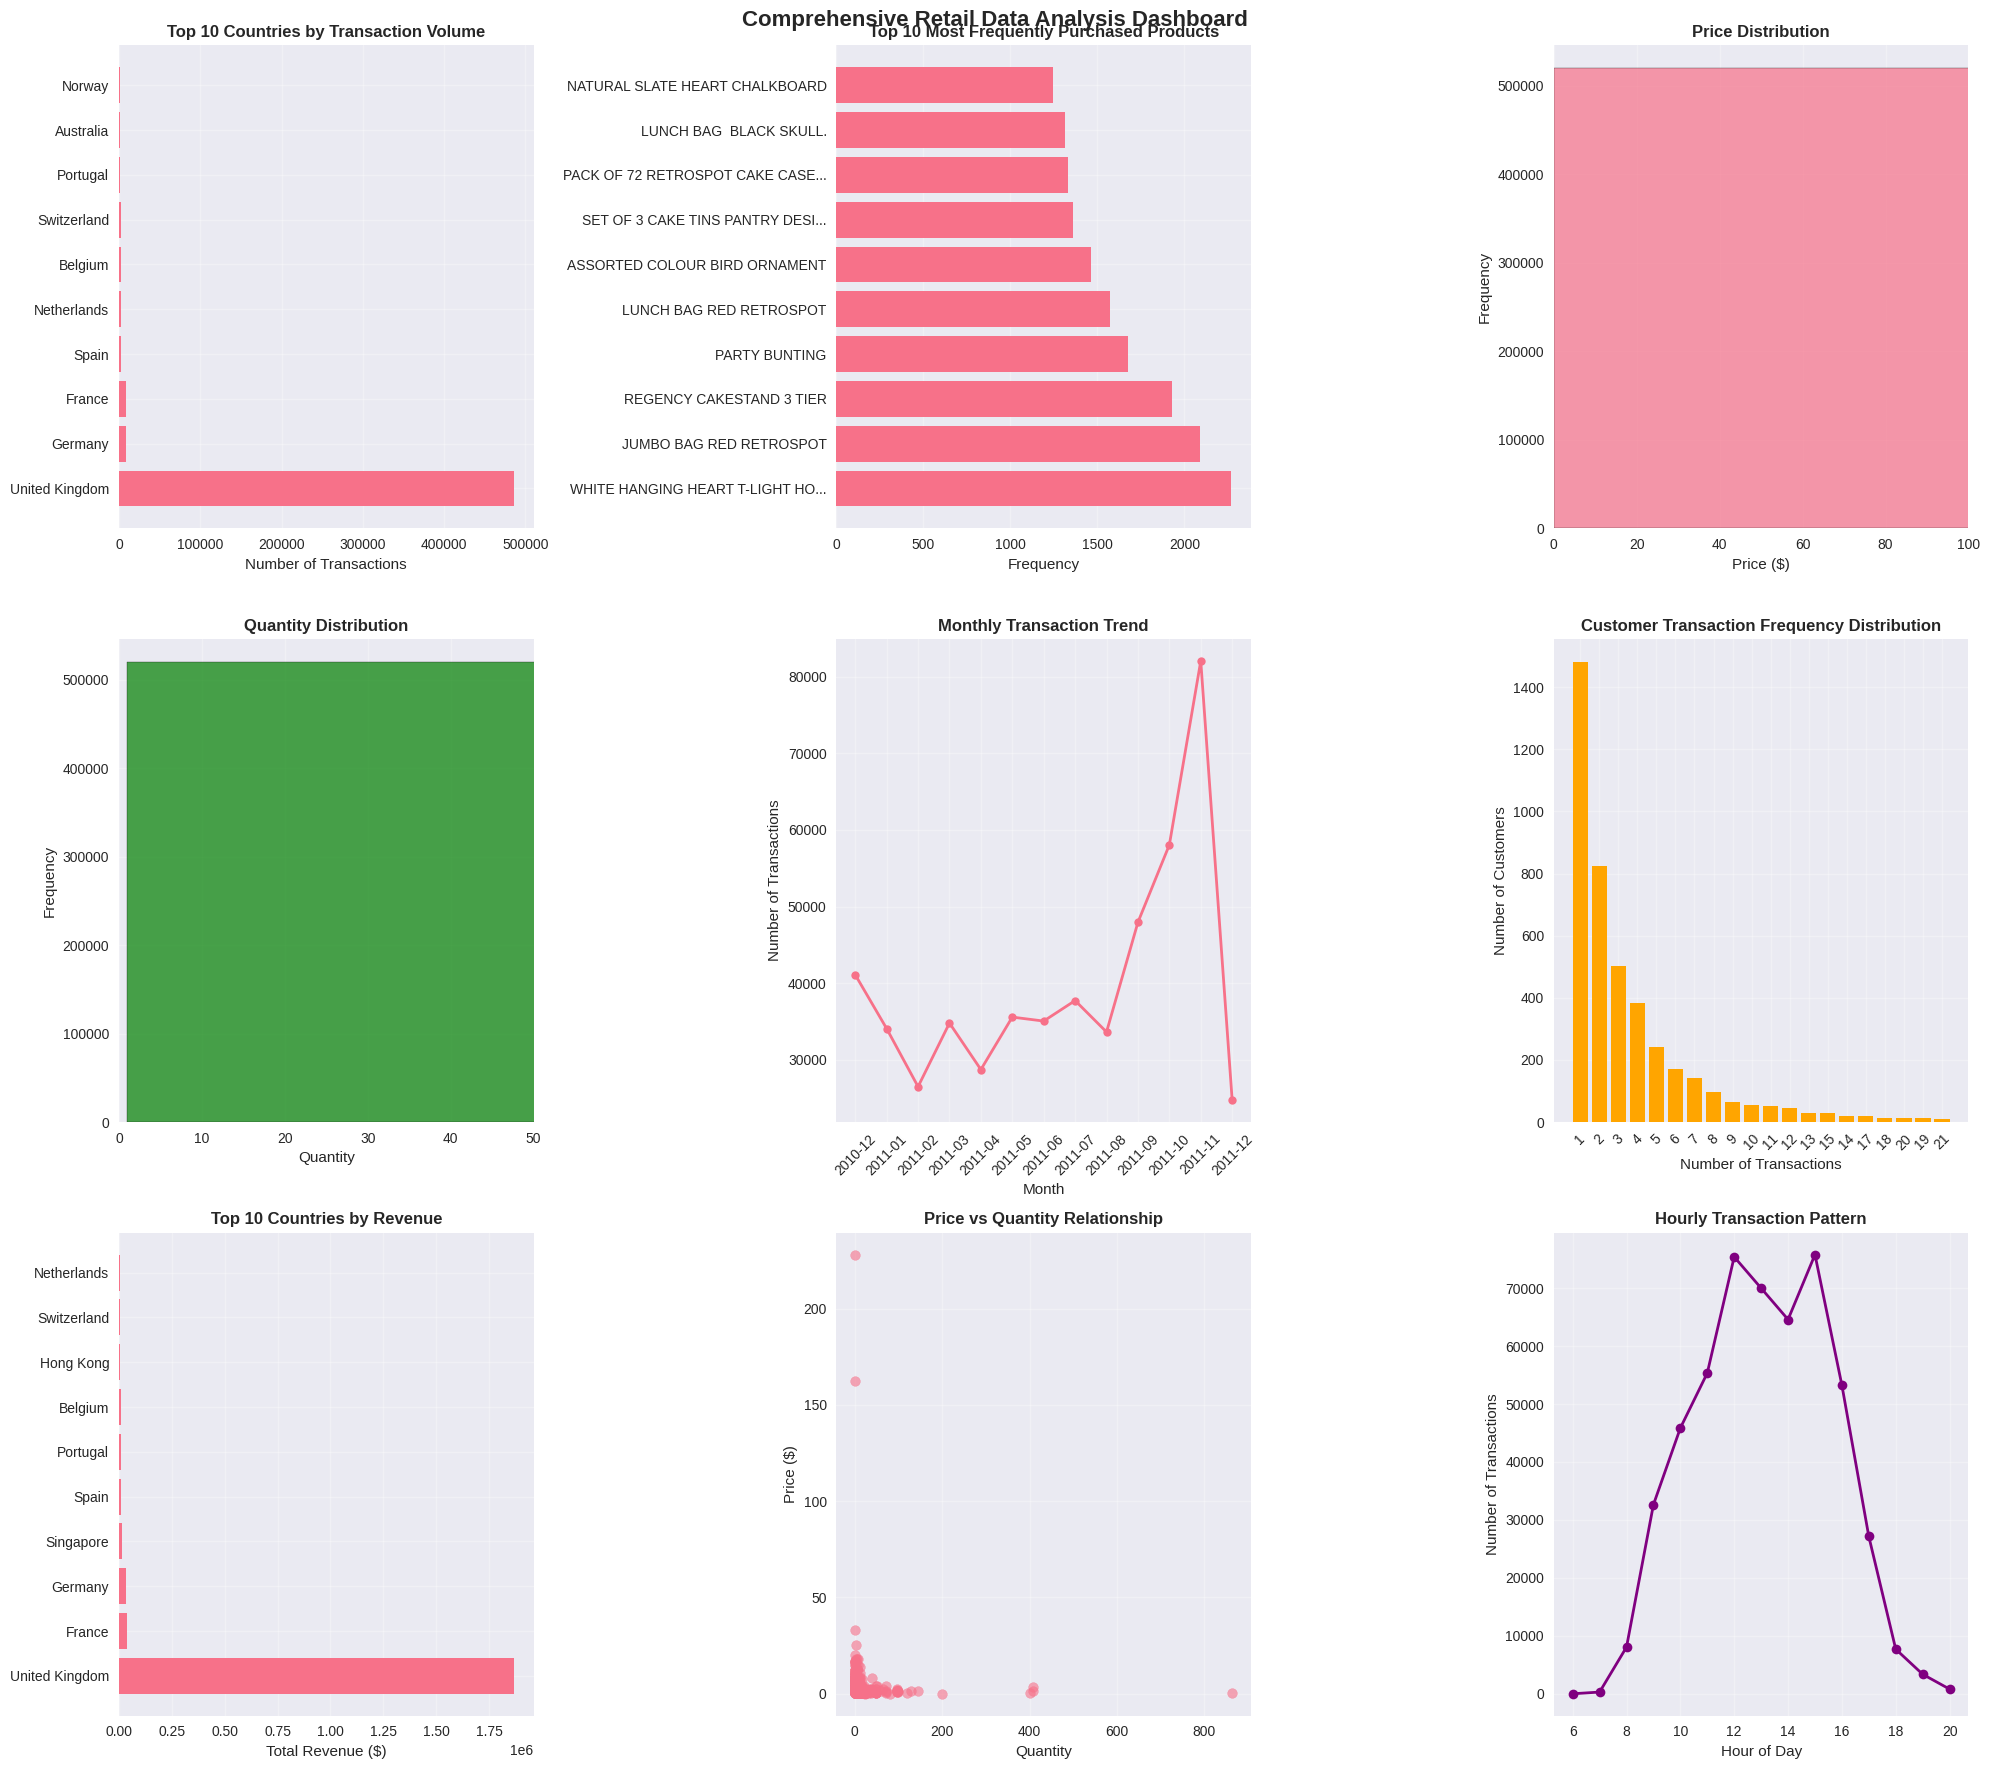

In [ ]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Comprehensive Retail Data Analysis Dashboard', fontsize=16, fontweight='bold')

# Top Countries by Transaction Volume
top_countries = country_counts.head(10)
axes[0, 0].barh(range(len(top_countries)), top_countries.values)
axes[0, 0].set_yticks(range(len(top_countries)))
axes[0, 0].set_yticklabels(top_countries.index)
axes[0, 0].set_xlabel('Number of Transactions')
axes[0, 0].set_title('Top 10 Countries by Transaction Volume', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Top Products by Frequency
top_20_products = top_products.head(10)
axes[0, 1].barh(range(len(top_20_products)), top_20_products.values)
axes[0, 1].set_yticks(range(len(top_20_products)))
axes[0, 1].set_yticklabels([str(x)[:30] + '...' if len(str(x)) > 30 else x for x in top_20_products.index])
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Top 10 Most Frequently Purchased Products', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Price Distribution
axes[0, 2].hist(df['Price'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Price ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Price Distribution', fontweight='bold')
axes[0, 2].set_xlim(0, 100)  # Focus on typical price range
axes[0, 2].grid(True, alpha=0.3)

# Quantity Distribution
axes[1, 0].hist(df['Quantity'], bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_xlabel('Quantity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Quantity Distribution', fontweight='bold')
axes[1, 0].set_xlim(0, 50)  # Focus on typical quantity range
axes[1, 0].grid(True, alpha=0.3)

# Monthly Transaction Trend
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M')
monthly_transactions = df.groupby('Month').size()

axes[1, 1].plot(range(len(monthly_transactions)), monthly_transactions.values,
                marker='o', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_title('Monthly Transaction Trend', fontweight='bold')
axes[1, 1].set_xticks(range(len(monthly_transactions)))
axes[1, 1].set_xticklabels([str(x) for x in monthly_transactions.index], rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Customer Transaction Distribution
customer_tx_counts = customer_transactions.value_counts().head(20)
axes[1, 2].bar(range(len(customer_tx_counts)), customer_tx_counts.values, color='orange')
axes[1, 2].set_xlabel('Number of Transactions')
axes[1, 2].set_ylabel('Number of Customers')
axes[1, 2].set_title('Customer Transaction Frequency Distribution', fontweight='bold')
axes[1, 2].set_xticks(range(len(customer_tx_counts)))
axes[1, 2].set_xticklabels(customer_tx_counts.index, rotation=45)
axes[1, 2].grid(True, alpha=0.3)

# Revenue by Country (Top 10)
country_revenue = df.groupby('Country')['Price'].sum().sort_values(ascending=False).head(10)
axes[2, 0].barh(range(len(country_revenue)), country_revenue.values)
axes[2, 0].set_yticks(range(len(country_revenue)))
axes[2, 0].set_yticklabels(country_revenue.index)
axes[2, 0].set_xlabel('Total Revenue ($)')
axes[2, 0].set_title('Top 10 Countries by Revenue', fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# Product Price vs Quantity Scatter
sample_df = df.sample(1000)  # Sample for better visualization
axes[2, 1].scatter(sample_df['Quantity'], sample_df['Price'], alpha=0.6)
axes[2, 1].set_xlabel('Quantity')
axes[2, 1].set_ylabel('Price ($)')
axes[2, 1].set_title('Price vs Quantity Relationship', fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)

# Hourly Transaction Pattern
df['Hour'] = df['Date'].dt.hour
hourly_transactions = df.groupby('Hour').size()
axes[2, 2].plot(hourly_transactions.index, hourly_transactions.values,
                marker='o', linewidth=2, color='purple')
axes[2, 2].set_xlabel('Hour of Day')
axes[2, 2].set_ylabel('Number of Transactions')
axes[2, 2].set_title('Hourly Transaction Pattern', fontweight='bold')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

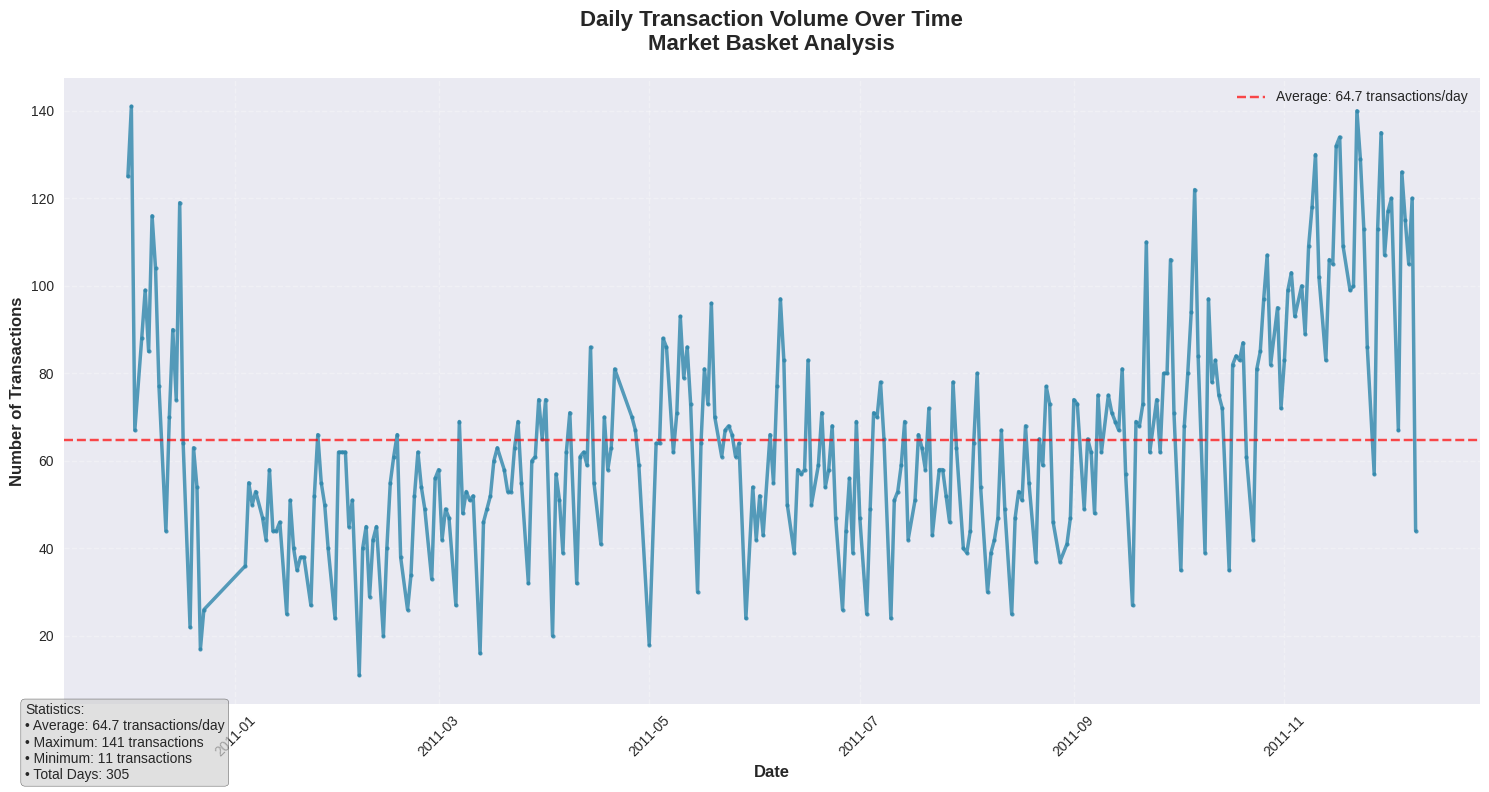

In [ ]:
# Calculate daily transaction volume
daily_volume = df.groupby(df['Date'].dt.date)['BillNo'].nunique()

plt.figure(figsize=(15, 8))
plt.plot(daily_volume.index, daily_volume.values,
         linewidth=2.5, color='#2E86AB', alpha=0.8, marker='o', markersize=3)
plt.title('Daily Transaction Volume Over Time\nMarket Basket Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')

# Add statistics annotations
mean_transactions = daily_volume.mean()
max_transactions = daily_volume.max()
min_transactions = daily_volume.min()

plt.axhline(y=mean_transactions, color='red', linestyle='--', alpha=0.7,
            label=f'Average: {mean_transactions:.1f} transactions/day')
plt.legend()

# Add text box with statistics
stats_text = f"""Statistics:
• Average: {mean_transactions:.1f} transactions/day
• Maximum: {max_transactions} transactions
• Minimum: {min_transactions} transactions
• Total Days: {len(daily_volume)}"""

plt.gcf().text(0.02, 0.02, stats_text, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

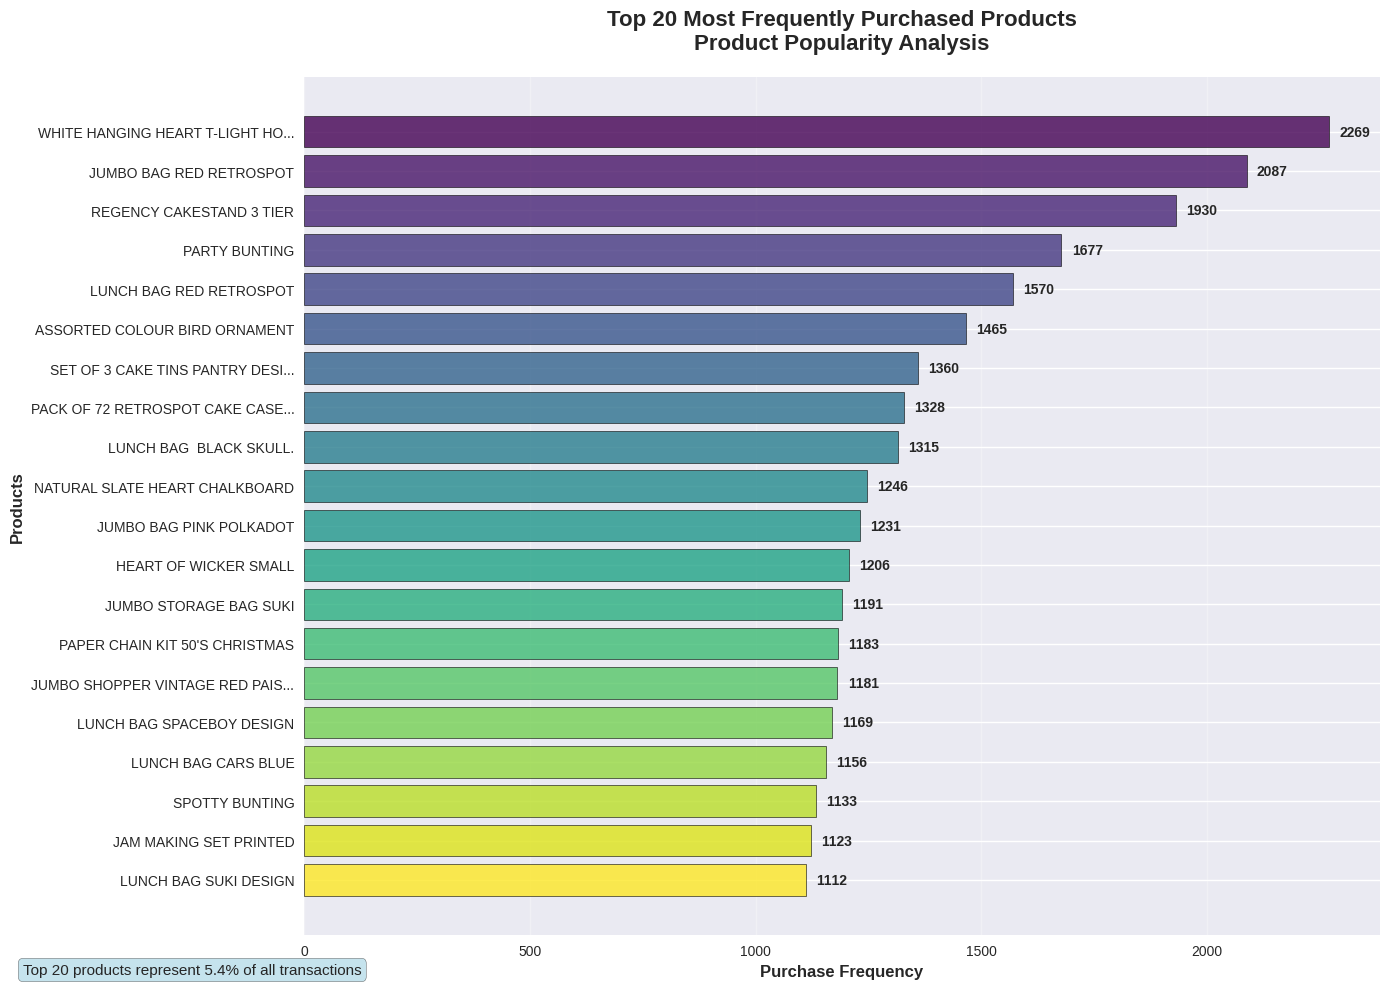

In [ ]:
# PRODUCTS BY PURCHASE FREQUENCY
top_products = df['Itemname'].value_counts().head(20)

plt.figure(figsize=(14, 10))
bars = plt.barh(range(len(top_products)), top_products.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(top_products))),
                alpha=0.8, edgecolor='black', linewidth=0.5)

plt.title('Top 20 Most Frequently Purchased Products\nProduct Popularity Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Purchase Frequency', fontsize=12, fontweight='bold')
plt.ylabel('Products', fontsize=12, fontweight='bold')
plt.yticks(range(len(top_products)),
           [str(x)[:30] + '...' if len(str(x)) > 30 else str(x) for x in top_products.index])

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(top_products.values)*0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()  # Highest frequency at top

# Add percentage annotations
total_transactions = len(df)
top_20_percentage = (top_products.sum() / total_transactions) * 100

plt.figtext(0.02, 0.02,
            f"Top 20 products represent {top_20_percentage:.1f}% of all transactions",
            fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()


3. CREATING SALES BY DAY OF WEEK PLOT...


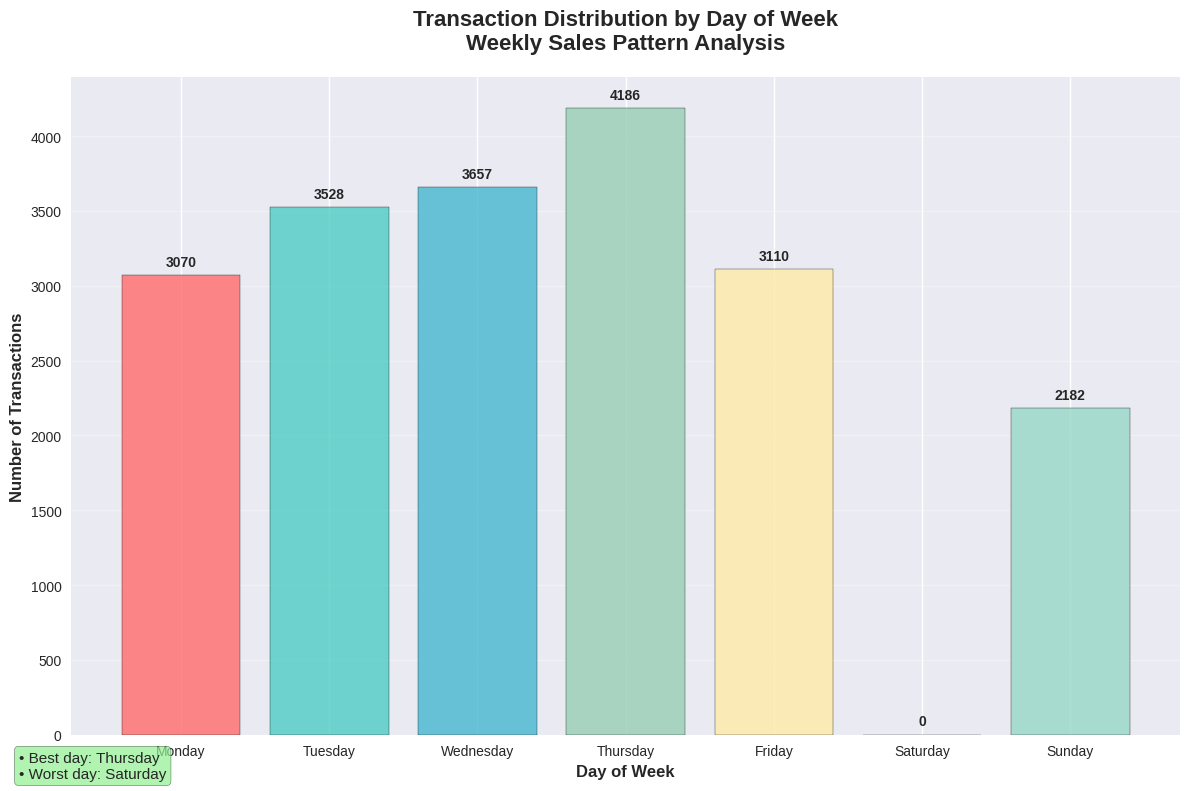

In [ ]:
# SALES BY DAY OF WEEK

print("\n3. CREATING SALES BY DAY OF WEEK PLOT...")

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_day = df.groupby('DayOfWeek')['BillNo'].nunique().reindex(day_order).fillna(0)

plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
bars = plt.bar(sales_by_day.index, sales_by_day.values, color=colors, alpha=0.8, edgecolor='black')

plt.title('Transaction Distribution by Day of Week\nWeekly Sales Pattern Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Day of Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(sales_by_day.values)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

# Highlight best and worst days
best_day = sales_by_day.idxmax()
worst_day = sales_by_day.idxmin()

plt.figtext(0.02, 0.02,
            f"• Best day: {best_day}\n• Worst day: {worst_day}",
            fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.show()


4. CREATING SALES BY HOUR OF DAY PLOT...


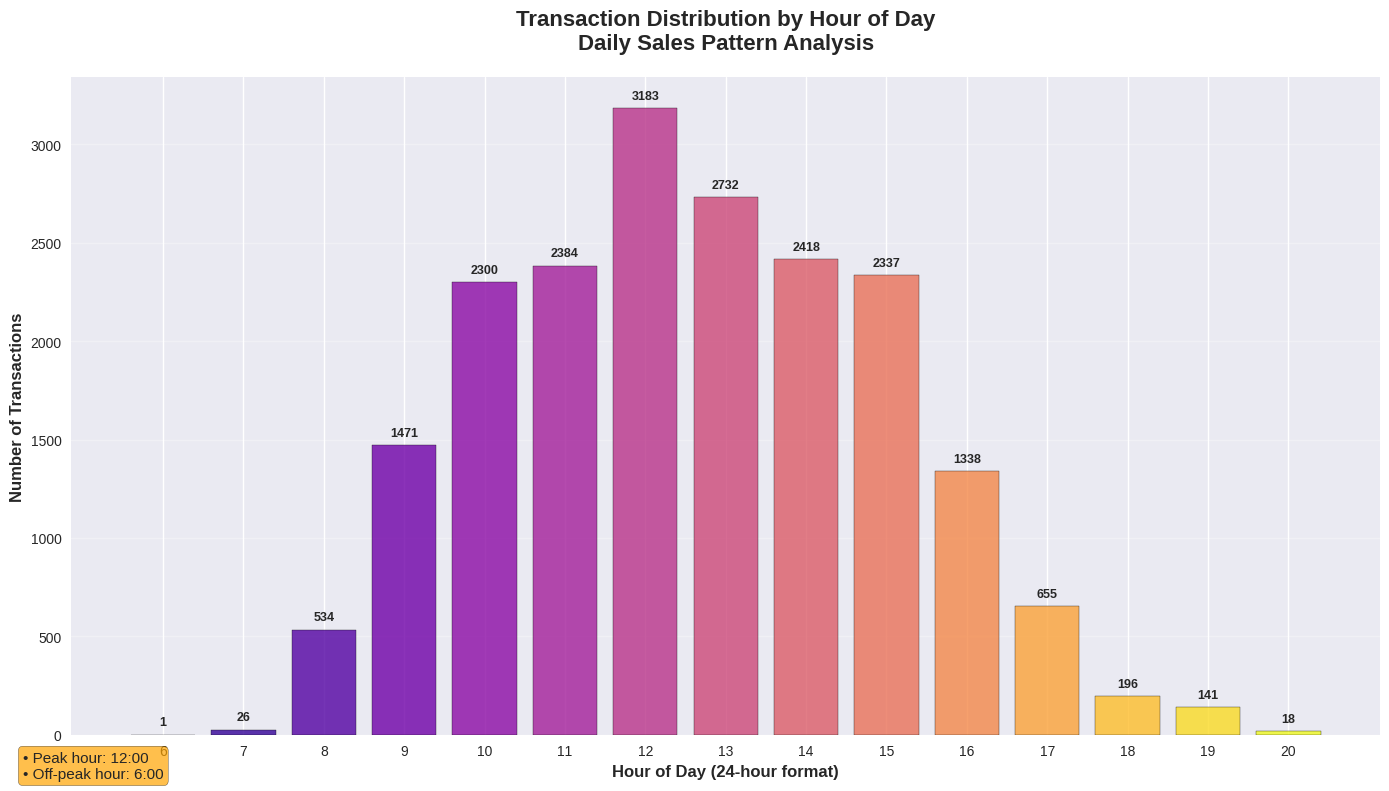

In [ ]:
# SALES BY HOUR OF DAY

print("\n4. CREATING SALES BY HOUR OF DAY PLOT...")

sales_by_hour = df.groupby('Hour')['BillNo'].nunique()

plt.figure(figsize=(14, 8))
bars = plt.bar(sales_by_hour.index, sales_by_hour.values,
               color=plt.cm.plasma(np.linspace(0, 1, len(sales_by_hour))),
               alpha=0.8, edgecolor='black')

plt.title('Transaction Distribution by Hour of Day\nDaily Sales Pattern Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(sales_by_hour.index)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(sales_by_hour.values)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

# Highlight peak hours
peak_hour = sales_by_hour.idxmax()
off_peak_hour = sales_by_hour.idxmin()

plt.figtext(0.02, 0.02,
            f"• Peak hour: {peak_hour}:00\n• Off-peak hour: {off_peak_hour}:00",
            fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7))

plt.tight_layout()
plt.show()

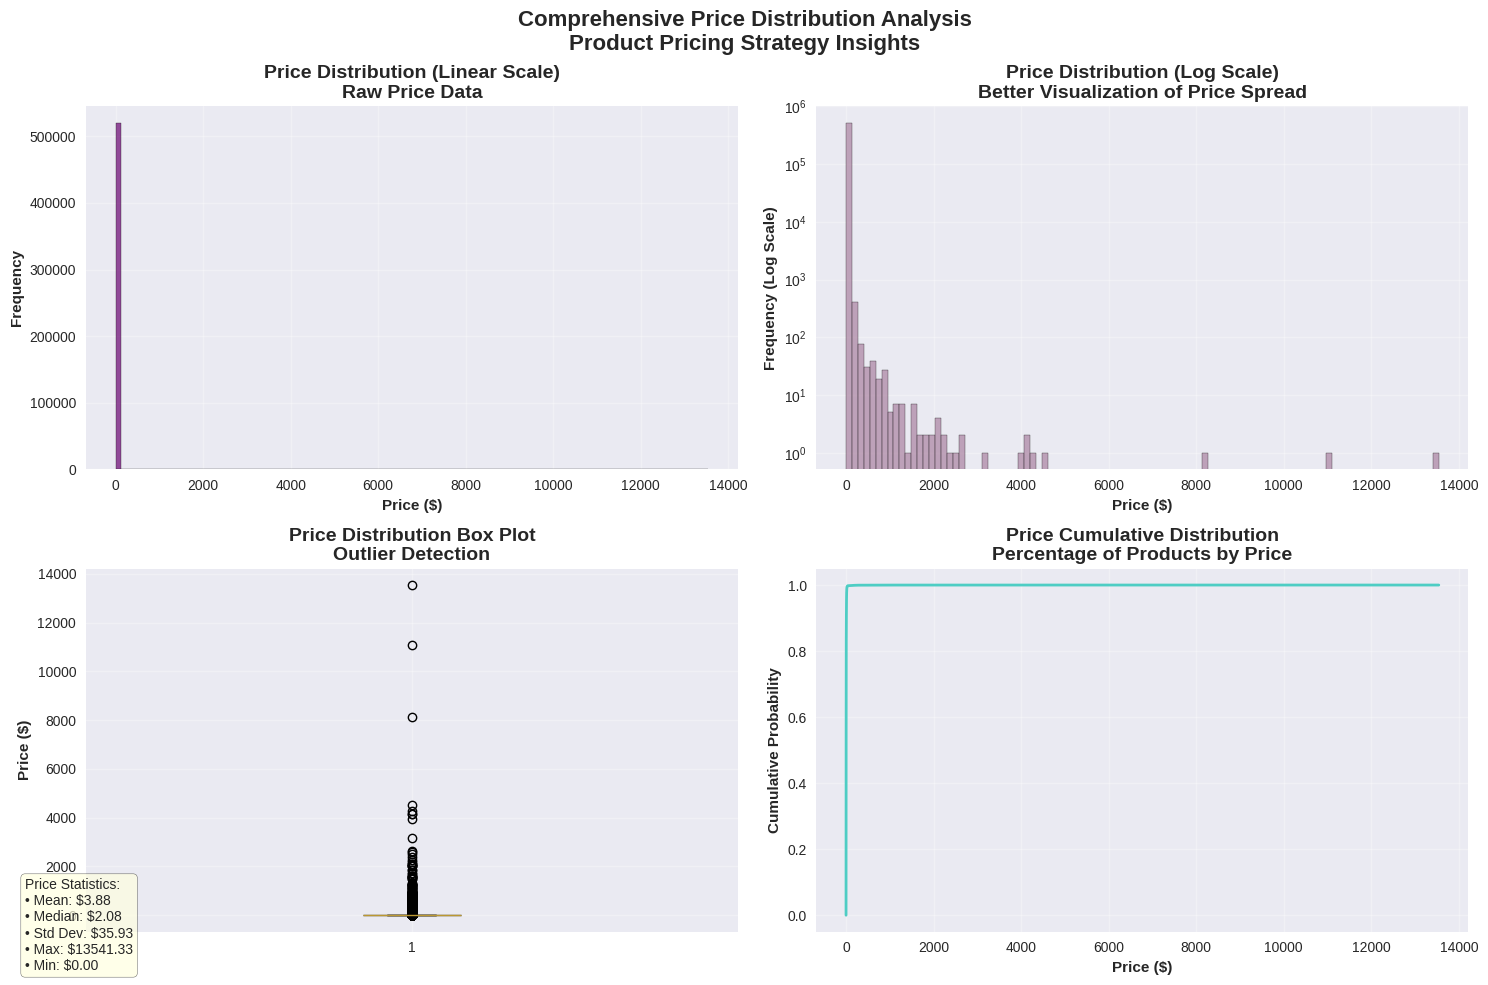

In [ ]:
# PRICE DISTRIBUTION ANALYSIS

plt.figure(figsize=(15, 10))

# Subplot 1: Linear scale
plt.subplot(2, 2, 1)
plt.hist(df['Price'], bins=100, color='#6A0572', alpha=0.7, edgecolor='black')
plt.title('Price Distribution (Linear Scale)\nRaw Price Data', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Log scale
plt.subplot(2, 2, 2)
plt.hist(df['Price'], bins=100, color='#AB83A1', alpha=0.7, edgecolor='black')
plt.yscale('log')
plt.title('Price Distribution (Log Scale)\nBetter Visualization of Price Spread',
          fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 3: Box plot
plt.subplot(2, 2, 3)
plt.boxplot(df['Price'], vert=True, patch_artist=True,
           boxprops=dict(facecolor='#FF6B6B', alpha=0.7))
plt.title('Price Distribution Box Plot\nOutlier Detection', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 4: Cumulative distribution
plt.subplot(2, 2, 4)
sorted_prices = np.sort(df['Price'])
yvals = np.arange(len(sorted_prices)) / float(len(sorted_prices))
plt.plot(sorted_prices, yvals, linewidth=2, color='#4ECDC4')
plt.title('Price Cumulative Distribution\nPercentage of Products by Price',
          fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Price Distribution Analysis\nProduct Pricing Strategy Insights',
             fontsize=16, fontweight='bold', y=0.98)

# Add statistics
price_stats = f"""Price Statistics:
• Mean: ${df['Price'].mean():.2f}
• Median: ${df['Price'].median():.2f}
• Std Dev: ${df['Price'].std():.2f}
• Max: ${df['Price'].max():.2f}
• Min: ${df['Price'].min():.2f}"""

plt.figtext(0.02, 0.02, price_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))

plt.tight_layout()
plt.show()

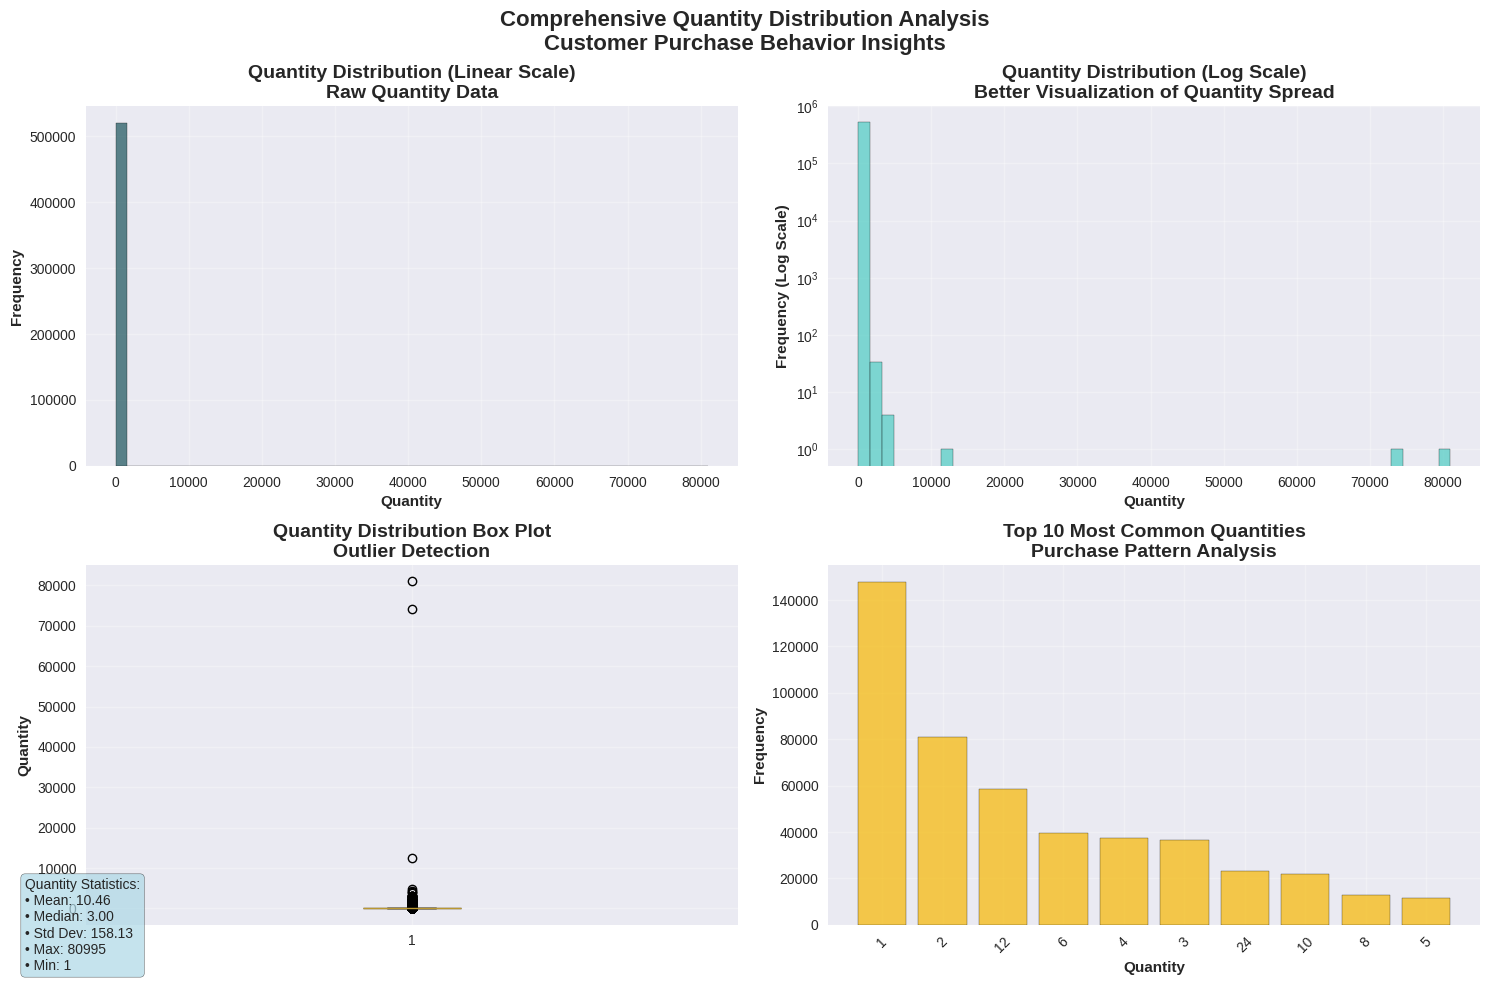

In [ ]:
# QUANTITY DISTRIBUTION ANALYSIS

plt.figure(figsize=(15, 10))

# Subplot 1: Linear scale
plt.subplot(2, 2, 1)
plt.hist(df['Quantity'], bins=50, color='#1A535C', alpha=0.7, edgecolor='black')
plt.title('Quantity Distribution (Linear Scale)\nRaw Quantity Data',
          fontsize=14, fontweight='bold')
plt.xlabel('Quantity', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Log scale
plt.subplot(2, 2, 2)
plt.hist(df['Quantity'], bins=50, color='#4ECDC4', alpha=0.7, edgecolor='black')
plt.yscale('log')
plt.title('Quantity Distribution (Log Scale)\nBetter Visualization of Quantity Spread',
          fontsize=14, fontweight='bold')
plt.xlabel('Quantity', fontsize=11, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 3: Box plot
plt.subplot(2, 2, 3)
plt.boxplot(df['Quantity'], vert=True, patch_artist=True,
           boxprops=dict(facecolor='#FF6B6B', alpha=0.7))
plt.title('Quantity Distribution Box Plot\nOutlier Detection',
          fontsize=14, fontweight='bold')
plt.ylabel('Quantity', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 4: Most common quantities
plt.subplot(2, 2, 4)
common_quantities = df['Quantity'].value_counts().head(10)
plt.bar(common_quantities.index.astype(str), common_quantities.values,
        color='#F7B801', alpha=0.7, edgecolor='black')
plt.title('Top 10 Most Common Quantities\nPurchase Pattern Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Quantity', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Quantity Distribution Analysis\nCustomer Purchase Behavior Insights',
             fontsize=16, fontweight='bold', y=0.98)

# Add statistics
quantity_stats = f"""Quantity Statistics:
• Mean: {df['Quantity'].mean():.2f}
• Median: {df['Quantity'].median():.2f}
• Std Dev: {df['Quantity'].std():.2f}
• Max: {df['Quantity'].max()}
• Min: {df['Quantity'].min()}"""

plt.figtext(0.02, 0.02, quantity_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

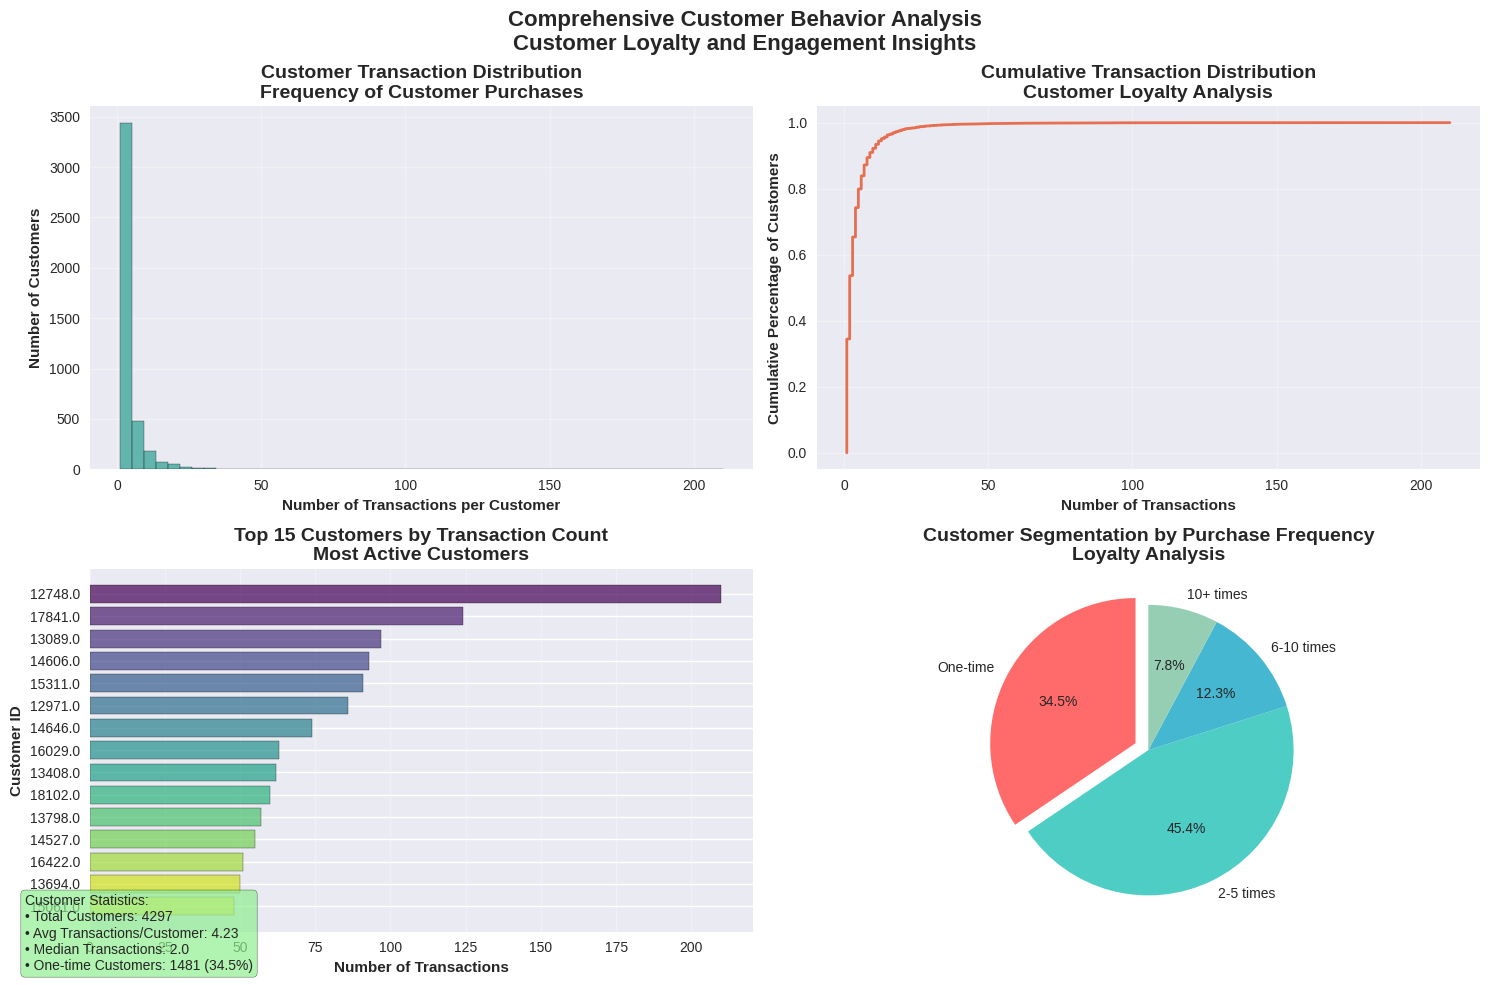

In [ ]:
# CUSTOMER TRANSACTION DISTRIBUTION

customer_tx_counts = df.groupby('CustomerID')['BillNo'].nunique()

plt.figure(figsize=(15, 10))

# Subplot 1: Histogram of transaction counts
plt.subplot(2, 2, 1)
plt.hist(customer_tx_counts, bins=50, color='#2A9D8F', alpha=0.7, edgecolor='black')
plt.title('Customer Transaction Distribution\nFrequency of Customer Purchases',
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Transactions per Customer', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Cumulative distribution
plt.subplot(2, 2, 2)
sorted_tx = np.sort(customer_tx_counts)
yvals = np.arange(len(sorted_tx)) / float(len(sorted_tx))
plt.plot(sorted_tx, yvals, linewidth=2, color='#E76F51')
plt.title('Cumulative Transaction Distribution\nCustomer Loyalty Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Percentage of Customers', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 3: Top customers by transactions
plt.subplot(2, 2, 3)
top_customers_tx = customer_tx_counts.nlargest(15)
plt.barh(range(len(top_customers_tx)), top_customers_tx.values,
         color=plt.cm.viridis(np.linspace(0, 1, len(top_customers_tx))),
         alpha=0.7, edgecolor='black')
plt.title('Top 15 Customers by Transaction Count\nMost Active Customers',
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=11, fontweight='bold')
plt.ylabel('Customer ID', fontsize=11, fontweight='bold')
plt.yticks(range(len(top_customers_tx)), top_customers_tx.index)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Subplot 4: Customer segmentation
plt.subplot(2, 2, 4)
segments = {
    'One-time': (customer_tx_counts == 1).sum(),
    '2-5 times': ((customer_tx_counts >= 2) & (customer_tx_counts <= 5)).sum(),
    '6-10 times': ((customer_tx_counts >= 6) & (customer_tx_counts <= 10)).sum(),
    '10+ times': (customer_tx_counts > 10).sum()
}

plt.pie(segments.values(), labels=segments.keys(), autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
        startangle=90, explode=(0.1, 0, 0, 0))
plt.title('Customer Segmentation by Purchase Frequency\nLoyalty Analysis',
          fontsize=14, fontweight='bold')

plt.suptitle('Comprehensive Customer Behavior Analysis\nCustomer Loyalty and Engagement Insights',
             fontsize=16, fontweight='bold', y=0.98)

# Add statistics
customer_stats = f"""Customer Statistics:
• Total Customers: {len(customer_tx_counts)}
• Avg Transactions/Customer: {customer_tx_counts.mean():.2f}
• Median Transactions: {customer_tx_counts.median():.1f}
• One-time Customers: {(customer_tx_counts == 1).sum()} ({((customer_tx_counts == 1).sum()/len(customer_tx_counts)*100):.1f}%)"""

plt.figtext(0.02, 0.02, customer_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.show()

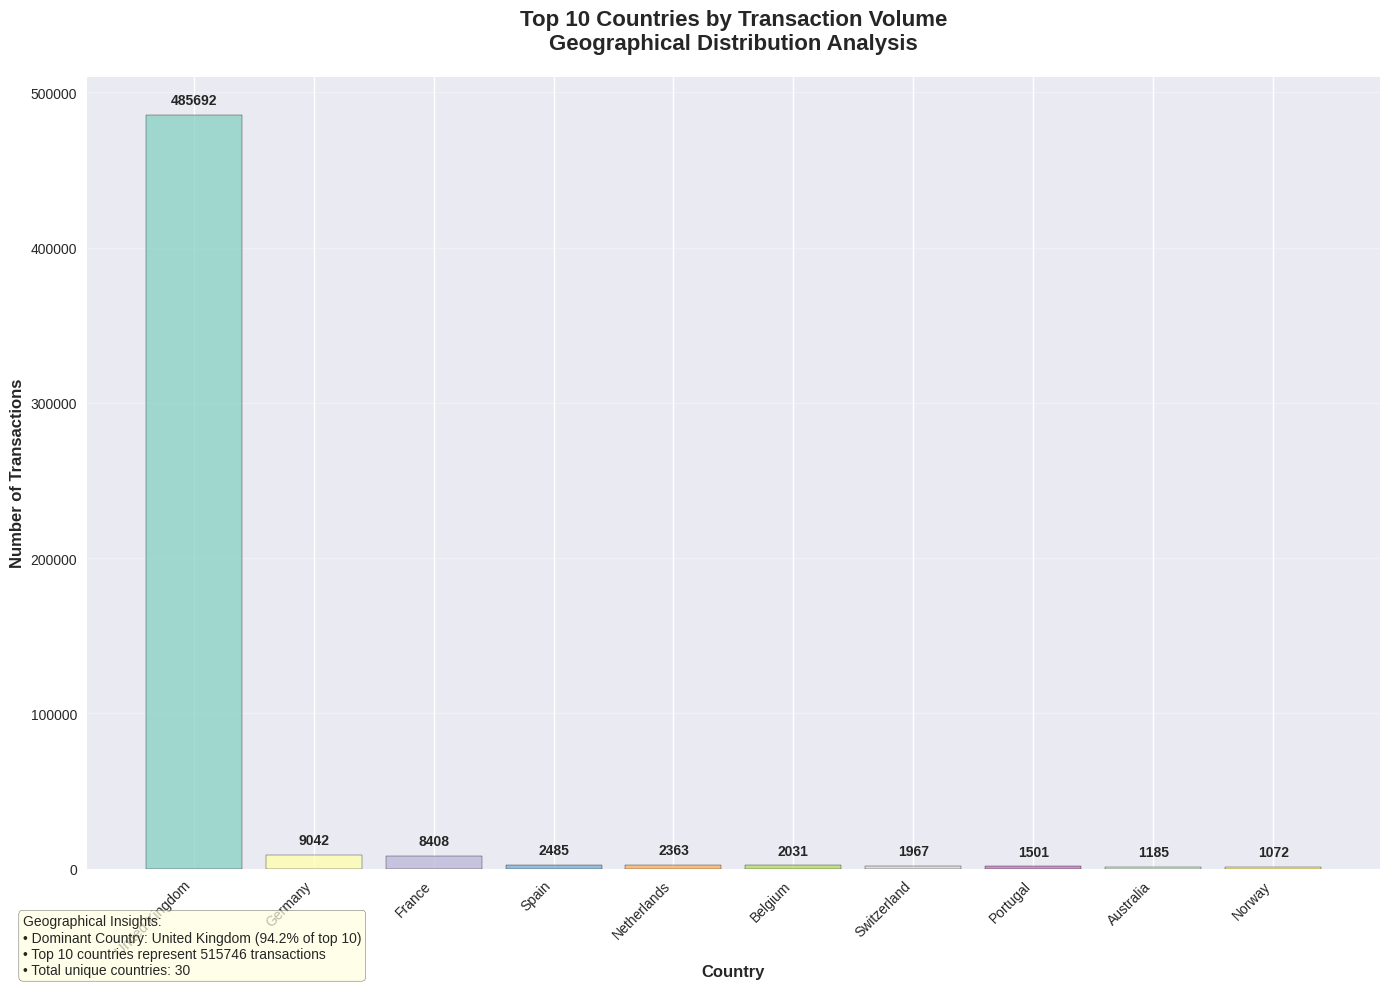

In [ ]:
# COUNTRY DISTRIBUTION ANALYSIS

country_dist = df['Country'].value_counts().head(10)

plt.figure(figsize=(14, 10))
colors = plt.cm.Set3(np.linspace(0, 1, len(country_dist)))
bars = plt.bar(range(len(country_dist)), country_dist.values,
               color=colors, alpha=0.8, edgecolor='black')

plt.title('Top 10 Countries by Transaction Volume\nGeographical Distribution Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Country', fontsize=12, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(len(country_dist)), country_dist.index, rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(country_dist.values)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

# Add percentage annotations
total_country_tx = country_dist.sum()
dominant_country_percentage = (country_dist.iloc[0] / total_country_tx) * 100

country_stats = f"""Geographical Insights:
• Dominant Country: {country_dist.index[0]} ({dominant_country_percentage:.1f}% of top 10)
• Top 10 countries represent {total_country_tx} transactions
• Total unique countries: {df['Country'].nunique()}"""

plt.figtext(0.02, 0.02, country_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))

plt.tight_layout()
plt.show()


9. CREATING REVENUE BY PRODUCT PLOT...


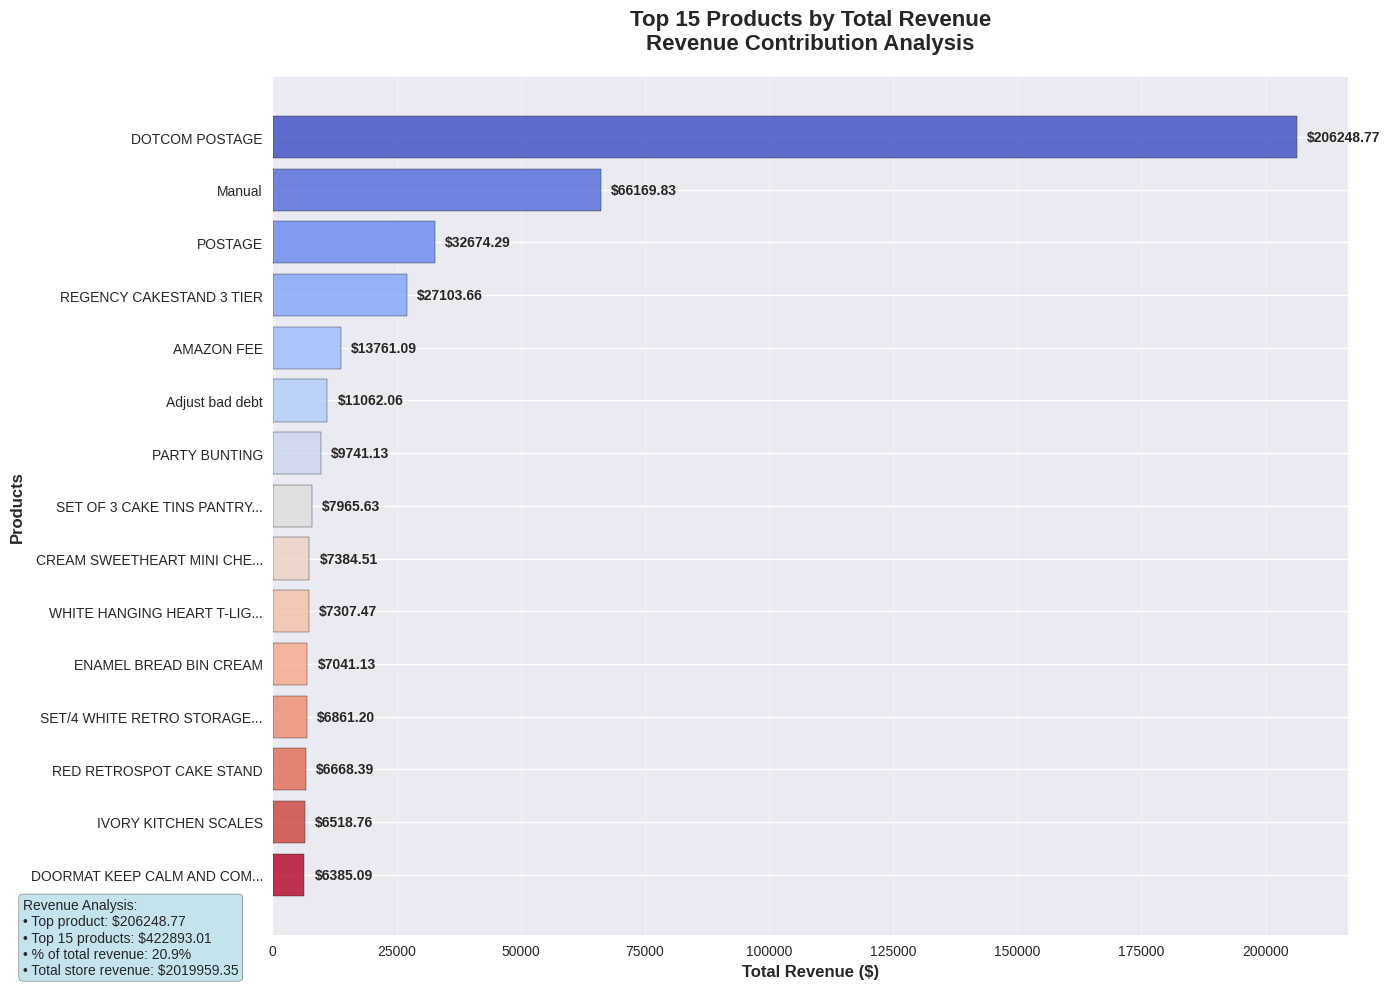

In [ ]:
# REVENUE BY PRODUCT ANALYSIS

print("\n9. CREATING REVENUE BY PRODUCT PLOT...")

product_revenue = df.groupby('Itemname')['Price'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(14, 10))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(product_revenue)))
bars = plt.barh(range(len(product_revenue)), product_revenue.values,
                color=colors, alpha=0.8, edgecolor='black')

plt.title('Top 15 Products by Total Revenue\nRevenue Contribution Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Total Revenue ($)', fontsize=12, fontweight='bold')
plt.ylabel('Products', fontsize=12, fontweight='bold')
plt.yticks(range(len(product_revenue)),
           [str(x)[:25] + '...' if len(str(x)) > 25 else str(x) for x in product_revenue.index])

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(product_revenue.values)*0.01, bar.get_y() + bar.get_height()/2,
             f'${width:.2f}', ha='left', va='center', fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()  # Highest revenue at top

# Add revenue statistics
total_revenue = df['Price'].sum()
top_15_revenue = product_revenue.sum()
revenue_percentage = (top_15_revenue / total_revenue) * 100

revenue_stats = f"""Revenue Analysis:
• Top product: ${product_revenue.iloc[0]:.2f}
• Top 15 products: ${top_15_revenue:.2f}
• % of total revenue: {revenue_percentage:.1f}%
• Total store revenue: ${total_revenue:.2f}"""

plt.figtext(0.02, 0.02, revenue_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

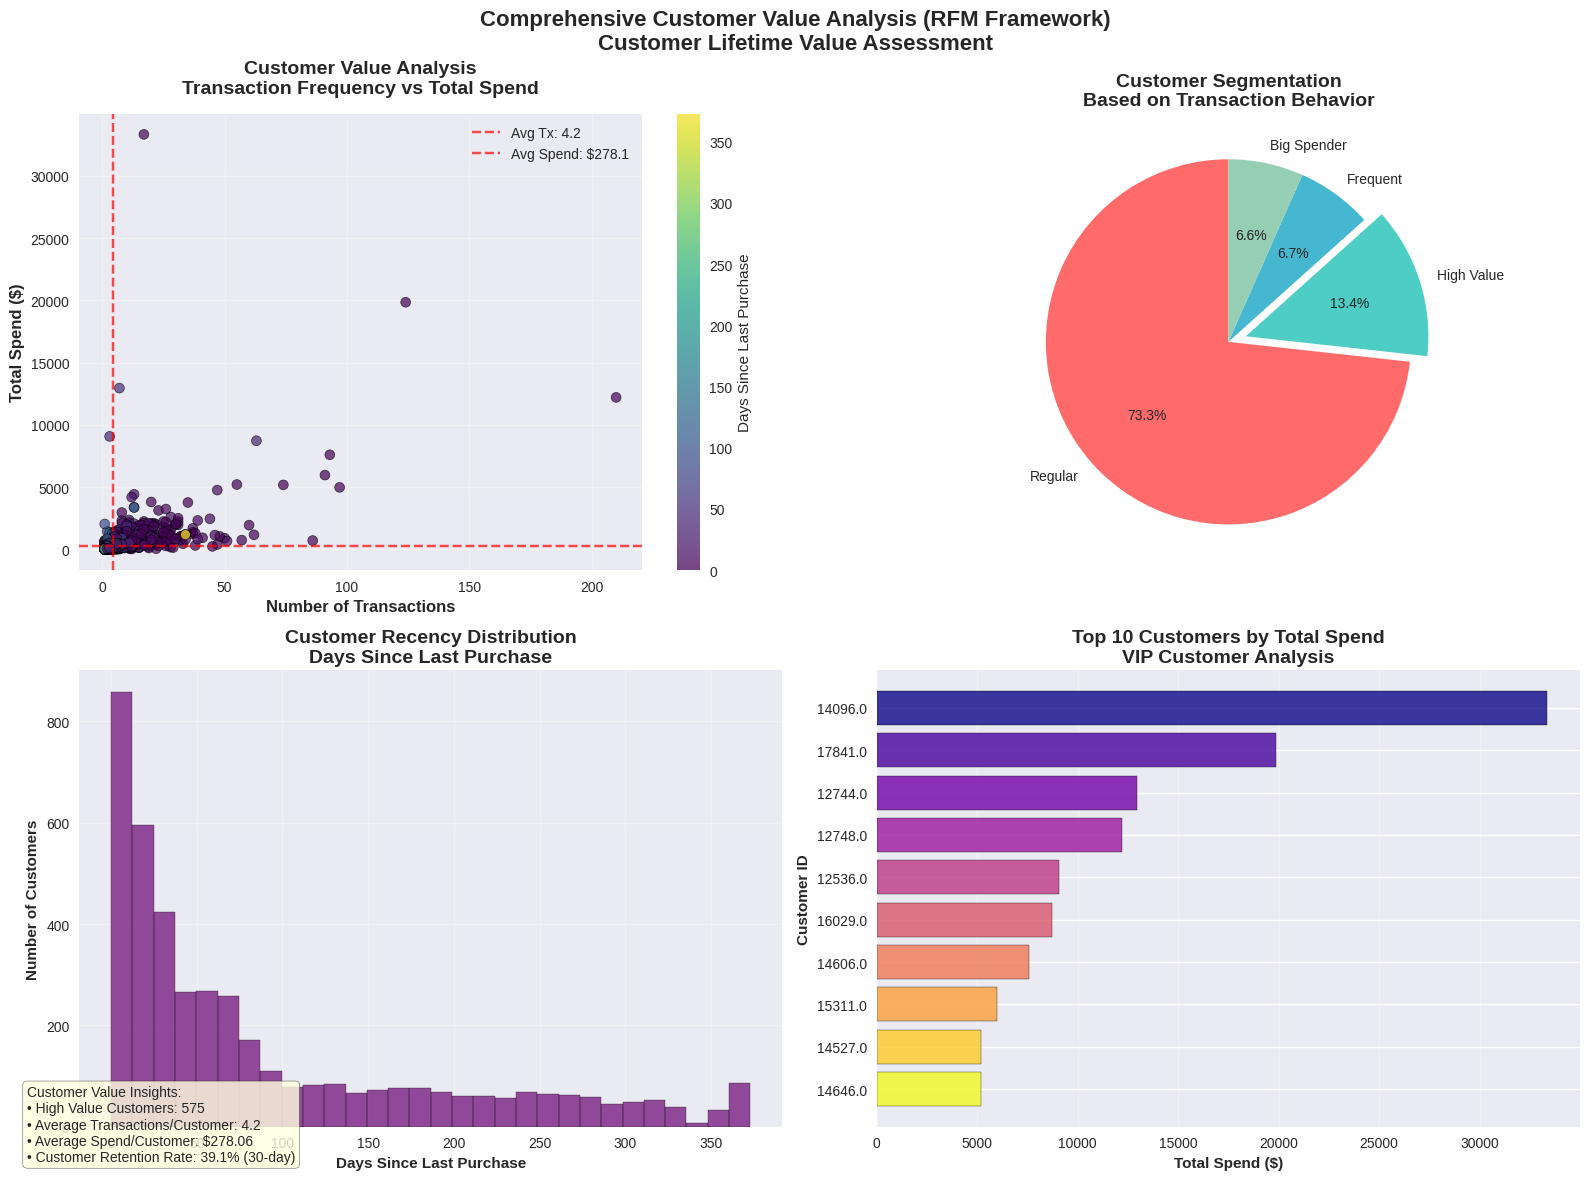

In [ ]:
# Calculate customer value metrics
customer_value = df.groupby('CustomerID').agg({
    'BillNo': 'nunique',
    'Price': 'sum',
    'Date': 'max'  # For recency analysis
}).rename(columns={
    'BillNo': 'TransactionCount',
    'Price': 'TotalSpend',
    'Date': 'LastPurchaseDate'
})

# Calculate recency (days since last purchase)
latest_date = df['Date'].max()
customer_value['DaysSinceLastPurchase'] = (latest_date - customer_value['LastPurchaseDate']).dt.days

plt.figure(figsize=(16, 12))

# Subplot 1: Transaction Count vs Total Spend
plt.subplot(2, 2, 1)
scatter = plt.scatter(customer_value['TransactionCount'], customer_value['TotalSpend'],
                     c=customer_value['DaysSinceLastPurchase'],
                     cmap='viridis', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Days Since Last Purchase')
plt.title('Customer Value Analysis\nTransaction Frequency vs Total Spend',
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.ylabel('Total Spend ($)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add customer segmentation lines
mean_tx = customer_value['TransactionCount'].mean()
mean_spend = customer_value['TotalSpend'].mean()
plt.axvline(x=mean_tx, color='red', linestyle='--', alpha=0.7, label=f'Avg Tx: {mean_tx:.1f}')
plt.axhline(y=mean_spend, color='red', linestyle='--', alpha=0.7, label=f'Avg Spend: ${mean_spend:.1f}')
plt.legend()

# Subplot 2: Customer Segmentation
plt.subplot(2, 2, 2)
# Define customer segments
conditions = [
    (customer_value['TransactionCount'] >= customer_value['TransactionCount'].quantile(0.8)) &
    (customer_value['TotalSpend'] >= customer_value['TotalSpend'].quantile(0.8)),
    (customer_value['TransactionCount'] >= customer_value['TransactionCount'].quantile(0.8)),
    (customer_value['TotalSpend'] >= customer_value['TotalSpend'].quantile(0.8)),
    (customer_value['TransactionCount'] < customer_value['TransactionCount'].quantile(0.8)) &
    (customer_value['TotalSpend'] < customer_value['TotalSpend'].quantile(0.8))
]

segments = ['High Value', 'Frequent', 'Big Spender', 'Regular']
customer_value['Segment'] = np.select(conditions, segments, default='Regular')

segment_counts = customer_value['Segment'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, explode=[0.1 if seg == 'High Value' else 0 for seg in segment_counts.index])
plt.title('Customer Segmentation\nBased on Transaction Behavior', fontsize=14, fontweight='bold')

# Subplot 3: Recency Distribution
plt.subplot(2, 2, 3)
plt.hist(customer_value['DaysSinceLastPurchase'], bins=30, color='#6A0572', alpha=0.7, edgecolor='black')
plt.title('Customer Recency Distribution\nDays Since Last Purchase', fontsize=14, fontweight='bold')
plt.xlabel('Days Since Last Purchase', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 4: Top 10 Customers by Value
plt.subplot(2, 2, 4)
top_customers = customer_value.nlargest(10, 'TotalSpend')
plt.barh(range(len(top_customers)), top_customers['TotalSpend'],
         color=plt.cm.plasma(np.linspace(0, 1, len(top_customers))),
         alpha=0.8, edgecolor='black')
plt.title('Top 10 Customers by Total Spend\nVIP Customer Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Total Spend ($)', fontsize=11, fontweight='bold')
plt.ylabel('Customer ID', fontsize=11, fontweight='bold')
plt.yticks(range(len(top_customers)), top_customers.index)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.suptitle('Comprehensive Customer Value Analysis (RFM Framework)\nCustomer Lifetime Value Assessment',
             fontsize=16, fontweight='bold', y=0.98)

# Add customer statistics
customer_stats = f"""Customer Value Insights:
• High Value Customers: {segment_counts.get('High Value', 0)}
• Average Transactions/Customer: {customer_value['TransactionCount'].mean():.1f}
• Average Spend/Customer: ${customer_value['TotalSpend'].mean():.2f}
• Customer Retention Rate: {(customer_value['DaysSinceLastPurchase'] <= 30).sum()/len(customer_value)*100:.1f}% (30-day)"""

plt.figtext(0.02, 0.02, customer_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.show()

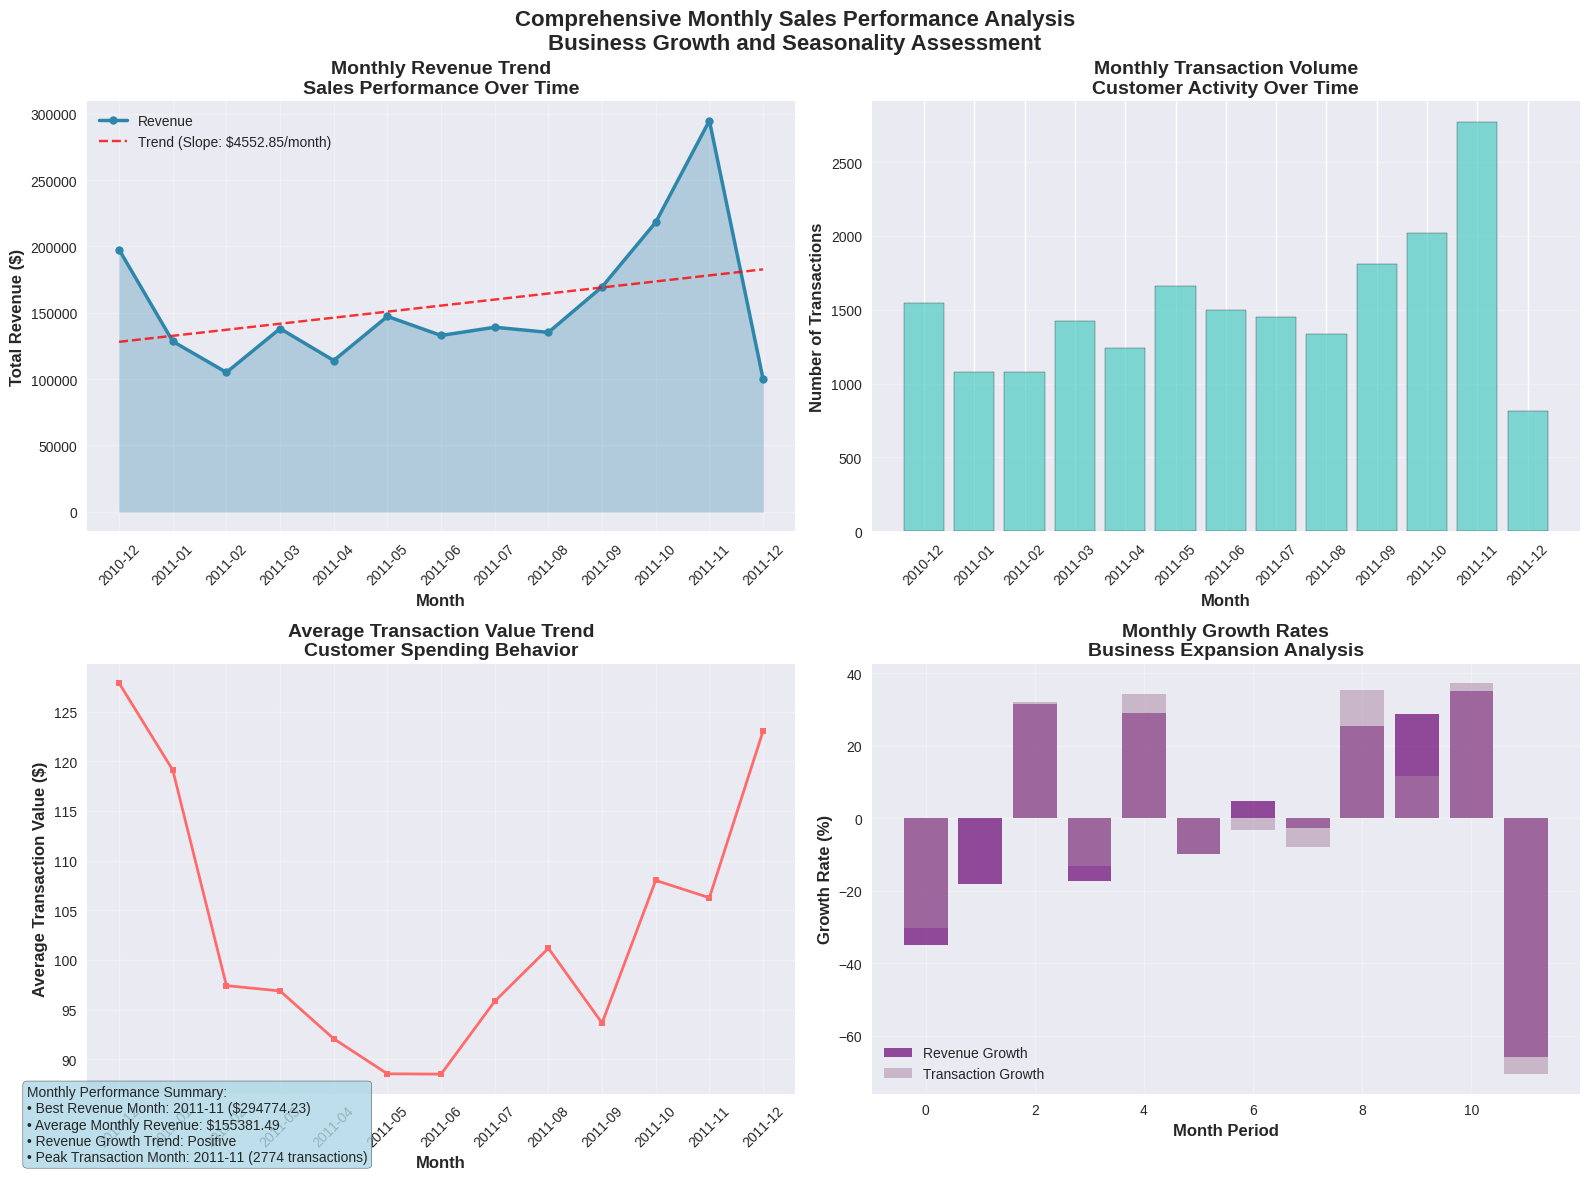

In [ ]:
# Calculate monthly metrics
monthly_data = df.groupby([df['Date'].dt.year, df['Date'].dt.month]).agg({
    'Price': 'sum',
    'BillNo': 'nunique',
    'CustomerID': 'nunique'
}).rename(columns={
    'Price': 'TotalRevenue',
    'BillNo': 'TransactionCount',
    'CustomerID': 'UniqueCustomers'
})
monthly_data.index = [f"{year}-{month:02d}" for year, month in monthly_data.index]

# Calculate average transaction value
monthly_data['AvgTransactionValue'] = monthly_data['TotalRevenue'] / monthly_data['TransactionCount']

plt.figure(figsize=(16, 12))

# Subplot 1: Monthly Revenue Trend
plt.subplot(2, 2, 1)
plt.plot(monthly_data.index, monthly_data['TotalRevenue'],
         marker='o', linewidth=2.5, color='#2E86AB', markersize=6, label='Revenue')
plt.fill_between(monthly_data.index, monthly_data['TotalRevenue'],
                 alpha=0.3, color='#2E86AB')
plt.title('Monthly Revenue Trend\nSales Performance Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# Add trend line
z = np.polyfit(range(len(monthly_data)), monthly_data['TotalRevenue'], 1)
p = np.poly1d(z)
plt.plot(monthly_data.index, p(range(len(monthly_data))), 'r--', alpha=0.8,
         label=f'Trend (Slope: ${z[0]:.2f}/month)')
plt.legend()

# Subplot 2: Monthly Transaction Count
plt.subplot(2, 2, 2)
plt.bar(monthly_data.index, monthly_data['TransactionCount'],
        color='#4ECDC4', alpha=0.7, edgecolor='black')
plt.title('Monthly Transaction Volume\nCustomer Activity Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Subplot 3: Average Transaction Value
plt.subplot(2, 2, 3)
plt.plot(monthly_data.index, monthly_data['AvgTransactionValue'],
         marker='s', linewidth=2, color='#FF6B6B', markersize=5)
plt.title('Average Transaction Value Trend\nCustomer Spending Behavior', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Average Transaction Value ($)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Subplot 4: Monthly Growth Rates
plt.subplot(2, 2, 4)
revenue_growth = monthly_data['TotalRevenue'].pct_change() * 100
transaction_growth = monthly_data['TransactionCount'].pct_change() * 100

x = range(len(revenue_growth.iloc[1:]))  # Skip first month (no growth)
plt.bar(x, revenue_growth.iloc[1:], alpha=0.7, label='Revenue Growth', color='#6A0572')
plt.bar(x, transaction_growth.iloc[1:], alpha=0.5, label='Transaction Growth', color='#AB83A1')
plt.title('Monthly Growth Rates\nBusiness Expansion Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Month Period', fontsize=12, fontweight='bold')
plt.ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Monthly Sales Performance Analysis\nBusiness Growth and Seasonality Assessment',
             fontsize=16, fontweight='bold', y=0.98)

# Add sales statistics
sales_stats = f"""Monthly Performance Summary:
• Best Revenue Month: {monthly_data['TotalRevenue'].idxmax()} (${monthly_data['TotalRevenue'].max():.2f})
• Average Monthly Revenue: ${monthly_data['TotalRevenue'].mean():.2f}
• Revenue Growth Trend: {'Positive' if z[0] > 0 else 'Negative'}
• Peak Transaction Month: {monthly_data['TransactionCount'].idxmax()} ({monthly_data['TransactionCount'].max()} transactions)"""

plt.figtext(0.02, 0.02, sales_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()

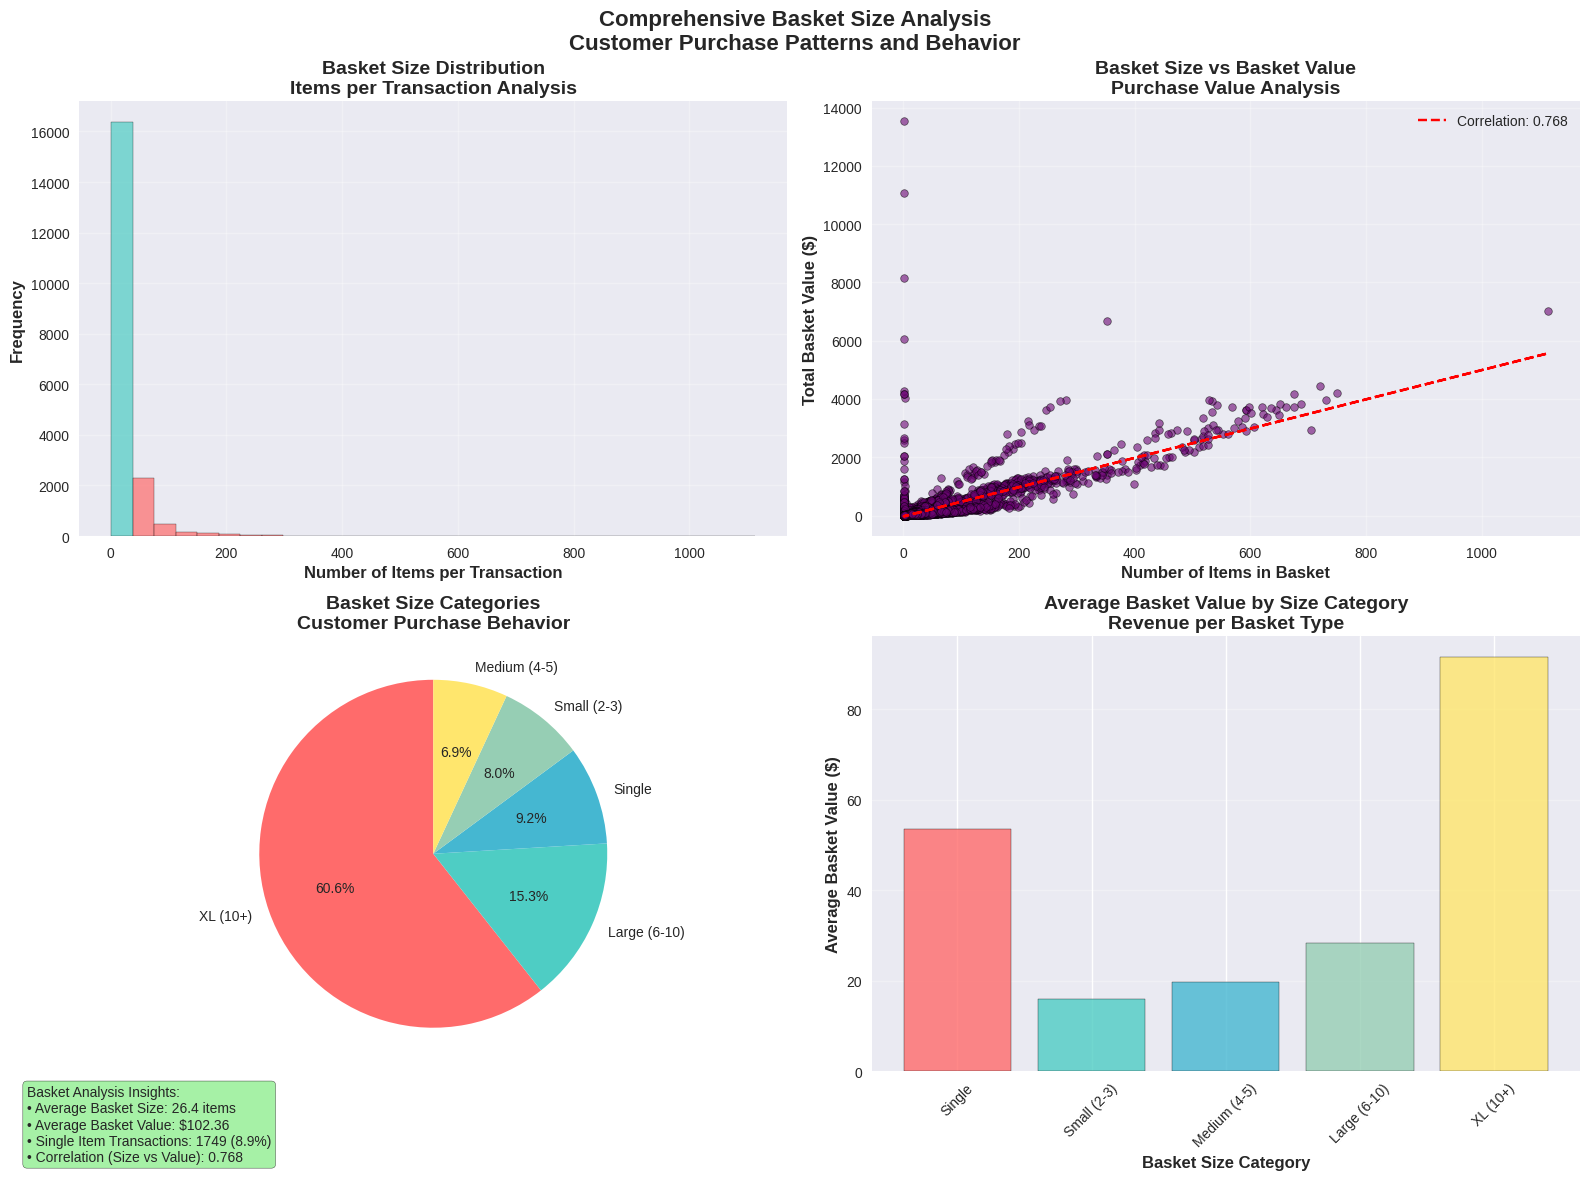

In [ ]:
# Calculate basket size metrics
basket_sizes = df.groupby('BillNo').agg({
    'Itemname': 'count',
    'Price': 'sum',
    'CustomerID': 'first'
}).rename(columns={
    'Itemname': 'BasketSize',
    'Price': 'BasketValue'
})

plt.figure(figsize=(16, 12))

# Subplot 1: Basket Size Distribution
plt.subplot(2, 2, 1)
n, bins, patches = plt.hist(basket_sizes['BasketSize'], bins=30,
                           color='#1A535C', alpha=0.7, edgecolor='black')
plt.title('Basket Size Distribution\nItems per Transaction Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Items per Transaction', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Color bars by basket size ranges
for i, (bin_val, patch) in enumerate(zip(bins, patches)):
    if bin_val < 5:
        patch.set_facecolor('#4ECDC4')  # Small baskets
    elif bin_val < 10:
        patch.set_facecolor('#FFE66D')  # Medium baskets
    else:
        patch.set_facecolor('#FF6B6B')  # Large baskets

# Subplot 2: Basket Size vs Basket Value
plt.subplot(2, 2, 2)
plt.scatter(basket_sizes['BasketSize'], basket_sizes['BasketValue'],
           alpha=0.6, color='#6A0572', s=30, edgecolors='black', linewidth=0.5)
plt.title('Basket Size vs Basket Value\nPurchase Value Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Number of Items in Basket', fontsize=12, fontweight='bold')
plt.ylabel('Total Basket Value ($)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add correlation line
z = np.polyfit(basket_sizes['BasketSize'], basket_sizes['BasketValue'], 1)
p = np.poly1d(z)
plt.plot(basket_sizes['BasketSize'], p(basket_sizes['BasketSize']), "r--",
         label=f'Correlation: {basket_sizes["BasketSize"].corr(basket_sizes["BasketValue"]):.3f}')
plt.legend()

# Subplot 3: Basket Size Categories
plt.subplot(2, 2, 3)
basket_categories = pd.cut(basket_sizes['BasketSize'],
                          bins=[0, 1, 3, 5, 10, 100],
                          labels=['Single', 'Small (2-3)', 'Medium (4-5)', 'Large (6-10)', 'XL (10+)'])
category_counts = basket_categories.value_counts()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFE66D']
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Basket Size Categories\nCustomer Purchase Behavior', fontsize=14, fontweight='bold')

# Subplot 4: Average Basket Value by Size
plt.subplot(2, 2, 4)
avg_value_by_size = basket_sizes.groupby(basket_categories)['BasketValue'].mean()
plt.bar(range(len(avg_value_by_size)), avg_value_by_size.values,
        color=colors, alpha=0.8, edgecolor='black')
plt.title('Average Basket Value by Size Category\nRevenue per Basket Type',
          fontsize=14, fontweight='bold')
plt.xlabel('Basket Size Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Basket Value ($)', fontsize=12, fontweight='bold')
plt.xticks(range(len(avg_value_by_size)), avg_value_by_size.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive Basket Size Analysis\nCustomer Purchase Patterns and Behavior',
             fontsize=16, fontweight='bold', y=0.98)

# Add basket statistics
basket_stats = f"""Basket Analysis Insights:
• Average Basket Size: {basket_sizes['BasketSize'].mean():.1f} items
• Average Basket Value: ${basket_sizes['BasketValue'].mean():.2f}
• Single Item Transactions: {(basket_sizes['BasketSize'] == 1).sum()} ({(basket_sizes['BasketSize'] == 1).sum()/len(basket_sizes)*100:.1f}%)
• Correlation (Size vs Value): {basket_sizes['BasketSize'].corr(basket_sizes['BasketValue']):.3f}"""

plt.figtext(0.02, 0.02, basket_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.show()

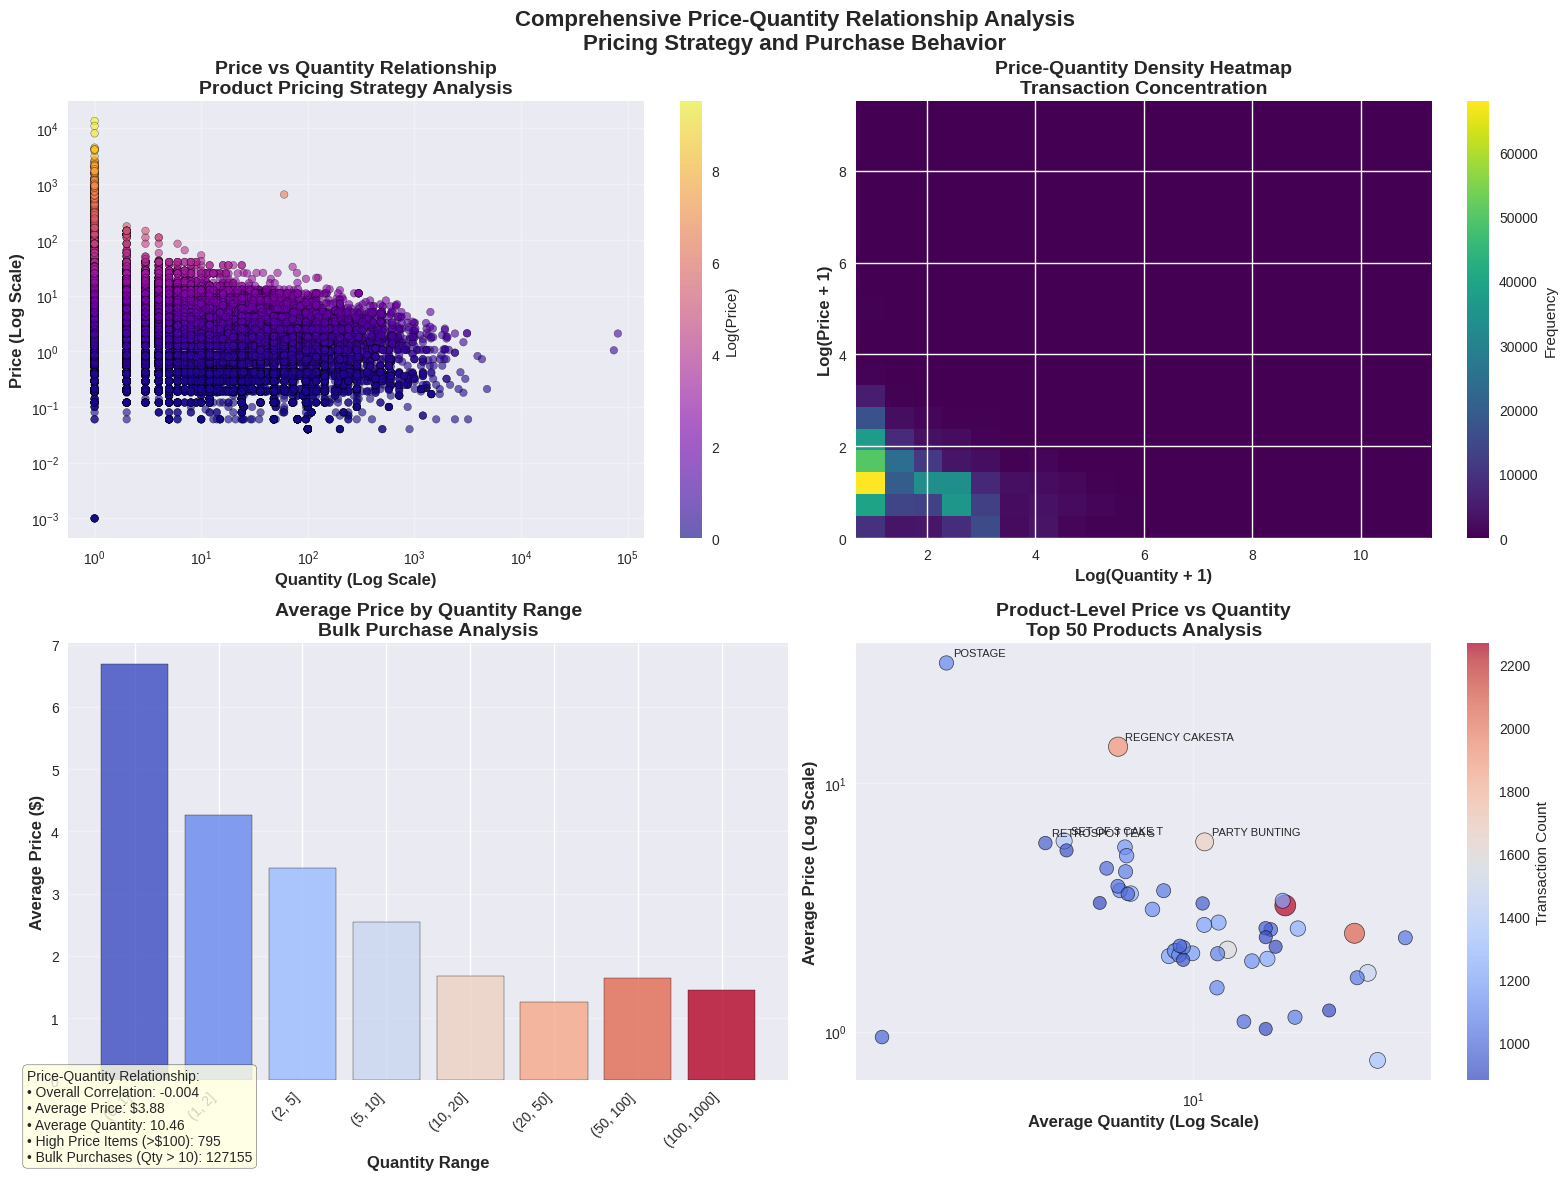

In [ ]:
# PRICE VS QUANTITY RELATIONSHIP ANALYSIS

plt.figure(figsize=(16, 12))
# Subplot 1: Scatter plot with density
plt.subplot(2, 2, 1)
scatter = plt.scatter(df['Quantity'], df['Price'],
                     c=np.log1p(df['Price']),  # Color by price (log scale for better visualization)
                     cmap='plasma', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
plt.colorbar(scatter, label='Log(Price)')
plt.xscale('log')
plt.yscale('log')
plt.title('Price vs Quantity Relationship\nProduct Pricing Strategy Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Quantity (Log Scale)', fontsize=12, fontweight='bold')
plt.ylabel('Price (Log Scale)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Price-Quantity Heatmap
plt.subplot(2, 2, 2)
# Create 2D histogram
heatmap, xedges, yedges = np.histogram2d(np.log1p(df['Quantity']), np.log1p(df['Price']), bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Frequency')
plt.title('Price-Quantity Density Heatmap\nTransaction Concentration',
          fontsize=14, fontweight='bold')
plt.xlabel('Log(Quantity + 1)', fontsize=12, fontweight='bold')
plt.ylabel('Log(Price + 1)', fontsize=12, fontweight='bold')

# Subplot 3: Average Price by Quantity Range
plt.subplot(2, 2, 3)
quantity_bins = pd.cut(df['Quantity'], bins=[0, 1, 2, 5, 10, 20, 50, 100, 1000])
avg_price_by_quantity = df.groupby(quantity_bins)['Price'].mean()
plt.bar(range(len(avg_price_by_quantity)), avg_price_by_quantity.values,
        color=plt.cm.coolwarm(np.linspace(0, 1, len(avg_price_by_quantity))),
        alpha=0.8, edgecolor='black')
plt.title('Average Price by Quantity Range\nBulk Purchase Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Quantity Range', fontsize=12, fontweight='bold')
plt.ylabel('Average Price ($)', fontsize=12, fontweight='bold')
plt.xticks(range(len(avg_price_by_quantity)),
           [str(x) for x in avg_price_by_quantity.index], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Subplot 4: Price-Quantity Correlation by Product Category (simplified)
plt.subplot(2, 2, 4)
# Group by product and calculate average price and quantity
product_stats = df.groupby('Itemname').agg({
    'Price': 'mean',
    'Quantity': 'mean',
    'BillNo': 'count'
}).rename(columns={'BillNo': 'TransactionCount'})

# Take top 50 products by transaction count for clarity
top_products = product_stats.nlargest(50, 'TransactionCount')

plt.scatter(top_products['Quantity'], top_products['Price'],
           s=top_products['TransactionCount']/10,  # Size by popularity
           c=top_products['TransactionCount'], cmap='coolwarm', alpha=0.7,
           edgecolors='black', linewidth=0.5)
plt.colorbar(label='Transaction Count')

# Add product labels for outliers
for idx, row in top_products.nlargest(5, 'Price').iterrows():
    plt.annotate(str(idx)[:15], (row['Quantity'], row['Price']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xscale('log')
plt.yscale('log')
plt.title('Product-Level Price vs Quantity\nTop 50 Products Analysis',
          fontsize=14, fontweight='bold')
plt.xlabel('Average Quantity (Log Scale)', fontsize=12, fontweight='bold')
plt.ylabel('Average Price (Log Scale)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Price-Quantity Relationship Analysis\nPricing Strategy and Purchase Behavior',
             fontsize=16, fontweight='bold', y=0.98)

# Add relationship statistics
price_quantity_corr = df['Price'].corr(df['Quantity'])
price_stats = f"""Price-Quantity Relationship:
• Overall Correlation: {price_quantity_corr:.3f}
• Average Price: ${df['Price'].mean():.2f}
• Average Quantity: {df['Quantity'].mean():.2f}
• High Price Items (>$100): {(df['Price'] > 100).sum()}
• Bulk Purchases (Qty > 10): {(df['Quantity'] > 10).sum()}"""

plt.figtext(0.02, 0.02, price_stats, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
# Remove missing values
original_shape = df.shape
df_clean = df.dropna(subset=['BillNo', 'Itemname'])
print(f"Removed {original_shape[0] - df_clean.shape[0]} rows with missing values")

Removed 0 rows with missing values


In [ ]:
# Remove negative quantities and prices
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['Price'] > 0]
print(f"Removed transactions with negative quantities/prices")

Removed transactions with negative quantities/prices


In [ ]:
# Remove cancelled transactions (typically have 'C' in BillNo)
cancelled_transactions = df_clean[df_clean['BillNo'].astype(str).str.contains('C', na=False)]
df_clean = df_clean[~df_clean['BillNo'].astype(str).str.contains('C', na=False)]
print(f"Removed {len(cancelled_transactions)} cancelled transactions")

Removed 0 cancelled transactions


In [ ]:
print(f"Final dataset shape: {df_clean.shape}")

Final dataset shape: (519551, 12)


In [ ]:
# Group items by transaction
transactions = df_clean.groupby('BillNo')['Itemname'].apply(list).reset_index()
print(f"Total number of transactions: {len(transactions)}")

Total number of transactions: 19559


In [ ]:
# Analyze transaction sizes & statistics
transaction_sizes = transactions['Itemname'].apply(len)
print(f"Average items per transaction: {transaction_sizes.mean():.2f}")
print(f"Minimum items in transaction: {transaction_sizes.min()}")
print(f"Maximum items in transaction: {transaction_sizes.max()}")

Average items per transaction: 26.56
Minimum items in transaction: 1
Maximum items in transaction: 1114


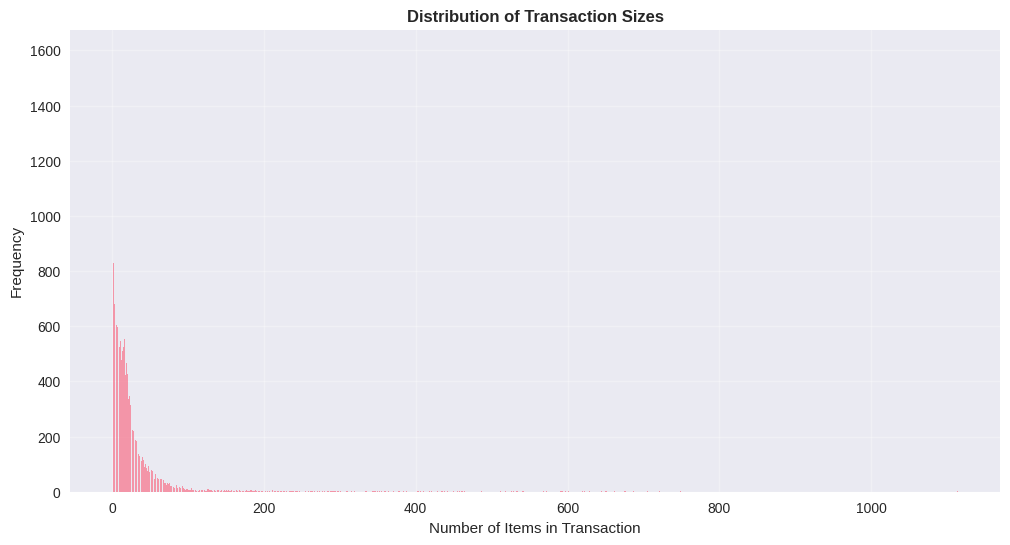

In [ ]:
# Distribution of transaction sizes
plt.figure(figsize=(12, 6))
transaction_size_counts = transaction_sizes.value_counts().sort_index()
plt.bar(transaction_size_counts.index, transaction_size_counts.values, alpha=0.7)
plt.xlabel('Number of Items in Transaction')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Sizes', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ASSOCIATION RULE MINING

# Prepare data for association rules
# Use TransactionEncoder to convert transactions to boolean array
te = TransactionEncoder()
te_array = te.fit(transactions['Itemname']).transform(transactions['Itemname'])
transaction_df = pd.DataFrame(te_array, columns=te.columns_)

In [ ]:
print(f"Transaction matrix shape: {transaction_df.shape}")
print(f"Number of unique items: {len(te.columns_)}")

Transaction matrix shape: (19559, 4006)
Number of unique items: 4006


In [ ]:
# Calculate frequent itemsets with minimum support
min_support = 0.01  # 1% minimum support
frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [ ]:
print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
print(f"Frequent itemsets by length:")
print(frequent_itemsets['length'].value_counts().sort_index())

In [ ]:
# Display top frequent itemsets
# Top 10 frequent itemsets
top_itemsets = frequent_itemsets.nlargest(10, 'support')
for idx, row in top_itemsets.iterrows():
    items = ', '.join(list(row['itemsets']))
    print(f"  Support: {row['support']:.4f} | Items: {items}")

In [ ]:
# Generate association rules
# GENERATING ASSOCIATION RULES

# Generate rules with minimum confidence
min_confidence = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

In [ ]:
print(f"Number of association rules generated: {len(rules)}")

In [ ]:
# Sort rules by confidence and lift
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

In [ ]:
# Association Rules (by confidence)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

In [ ]:
# Rule Quality Analysis
# Calculate additional metrics
rules['conviction'] = (1 - rules['support']) / (1 - rules['confidence'])
rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])

In [ ]:
print(f"Rule quality metrics summary:")
print(f"Average confidence: {rules['confidence'].mean():.4f}")
print(f"Average lift: {rules['lift'].mean():.4f}")
print(f"Average conviction: {rules['conviction'].mean():.4f}")

In [ ]:
# Comprehensive Rule Visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Association Rules Analysis Dashboard', fontsize=16, fontweight='bold')

# Support vs Confidence scatter
scatter = axes[0, 0].scatter(rules['support'], rules['confidence'],
                            c=rules['lift'], cmap='viridis', alpha=0.6)
axes[0, 0].set_xlabel('Support')
axes[0, 0].set_ylabel('Confidence')
axes[0, 0].set_title('Support vs Confidence (Color: Lift)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 0])

# Lift Distribution
axes[0, 1].hist(rules['lift'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=1, color='red', linestyle='--', label='Lift = 1')
axes[0, 1].set_xlabel('Lift')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Lift Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confidence Distribution
axes[0, 2].hist(rules['confidence'], bins=30, alpha=0.7, edgecolor='black', color='green')
axes[0, 2].set_xlabel('Confidence')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Confidence Distribution', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Top Rules by Lift
top_rules_lift = rules.nlargest(10, 'lift')
rule_labels = []
for idx, row in top_rules_lift.iterrows():
    ante = list(row['antecedents'])[0] if len(row['antecedents']) == 1 else f"{len(row['antecedents'])} items"
    cons = list(row['consequents'])[0] if len(row['consequents']) == 1 else f"{len(row['consequents'])} items"
    rule_labels.append(f"{ante} → {cons}")

y_pos = range(len(rule_labels))
axes[1, 0].barh(y_pos, top_rules_lift['lift'])
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(rule_labels)
axes[1, 0].set_xlabel('Lift')
axes[1, 0].set_title('Top 10 Rules by Lift', fontweight='bold')

# Rule Length Distribution
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))
rule_length_counts = rules['antecedent_len'].value_counts().sort_index()

axes[1, 1].bar(rule_length_counts.index, rule_length_counts.values, alpha=0.7)
axes[1, 1].set_xlabel('Number of Items in Antecedent')
axes[1, 1].set_ylabel('Number of Rules')
axes[1, 1].set_title('Rule Length Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Support vs Lift
scatter2 = axes[1, 2].scatter(rules['support'], rules['lift'],
                             c=rules['confidence'], cmap='plasma', alpha=0.6)
axes[1, 2].set_xlabel('Support')
axes[1, 2].set_ylabel('Lift')
axes[1, 2].set_title('Support vs Lift (Color: Confidence)', fontweight='bold')
plt.colorbar(scatter2, ax=axes[1, 2])

plt.tight_layout()
plt.show()

In [ ]:
# Network Visualization of Association Rules
# Create a network graph for top rules
plt.figure(figsize=(15, 10))
G = nx.DiGraph()

In [ ]:
# Add nodes and edges for top rules
top_rules_network = rules.head(20)

for idx, rule in top_rules_network.iterrows():
    antecedents = list(rule['antecedents'])
    consequents = list(rule['consequents'])

    for ante in antecedents:
        for cons in consequents:
            G.add_edge(ante, cons, weight=rule['confidence'],
                      support=rule['support'], lift=rule['lift'])

In [ ]:
# Create layout
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the network
node_sizes = [G.degree(node) * 100 for node in G.nodes()]
edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                      node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_widths,
                      edge_color='gray', alpha=0.6, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Association Rules Network Visualization\n(Edge thickness = Confidence)',
          fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# DEEP LEARNING PRODUCT RECOMMENDATION SYSTEM

class ProductEmbeddingModel(nn.Module):
    def __init__(self, num_products, embedding_dim=50):
        super(ProductEmbeddingModel, self).__init__()
        self.product_embeddings = nn.Embedding(num_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_products)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_products, target_products):
        input_emb = self.product_embeddings(input_products)
        target_emb = self.product_embeddings(target_products)

        # Combine embeddings
        combined = torch.cat([input_emb, target_emb], dim=1)

        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
# Prepare data for neural network
# Create product to index mapping
all_products = list(te.columns_)
product_to_idx = {product: idx for idx, product in enumerate(all_products)}
idx_to_product = {idx: product for product, idx in product_to_idx.items()}

In [ ]:
print(f"Total products for embedding: {len(all_products)}")

In [ ]:
# Create training pairs from transactions
training_pairs = []
for transaction in transactions['Itemname']:
    if len(transaction) >= 2:
        for i in range(len(transaction)):
            for j in range(len(transaction)):
                if i != j:
                    training_pairs.append((
                        product_to_idx[transaction[i]],
                        product_to_idx[transaction[j]]
                    ))

In [ ]:
print(f"Number of training pairs: {len(training_pairs)}")

In [ ]:
# Convert to tensors
input_products = torch.tensor([pair[0] for pair in training_pairs])
target_products = torch.tensor([pair[1] for pair in training_pairs])

In [ ]:
# Create dataset and dataloader
class ProductDataset(Dataset):
    def __init__(self, input_products, target_products):
        self.input_products = input_products
        self.target_products = target_products

    def __len__(self):
        return len(self.input_products)

    def __getitem__(self, idx):
        return self.input_products[idx], self.target_products[idx]

In [ ]:
dataset = ProductDataset(input_products, target_products)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [ ]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ProductEmbeddingModel(len(all_products)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

In [ ]:
# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_input, batch_target in dataloader:
            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            optimizer.zero_grad()
            outputs = model(batch_input, batch_target)
            loss = criterion(outputs, batch_target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return losses

In [ ]:
# Train the model
losses = train_model(model, dataloader, criterion, optimizer, epochs=20)

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Product Embedding Model', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Product Recommendations using Embeddings

def get_similar_products(product_name, top_k=10):
    """Get similar products using learned embeddings"""
    if product_name not in product_to_idx:
        return f"Product '{product_name}' not found in database"

    model.eval()
    with torch.no_grad():
        product_idx = product_to_idx[product_name]
        product_embedding = model.product_embeddings(
            torch.tensor([product_idx]).to(device)
        )

        # Calculate similarities with all other products
        all_embeddings = model.product_embeddings.weight.data
        similarities = torch.cosine_similarity(product_embedding, all_embeddings)

        # Get top similar products (excluding the input product itself)
        top_indices = similarities.argsort(descending=True)[1:top_k+1]

        similar_products = []
        for idx in top_indices.cpu().numpy():
            similar_products.append({
                'product': idx_to_product[idx],
                'similarity': similarities[idx].item()
            })

    return similar_products

In [ ]:
# Test recommendations for popular products
test_products = top_products.head(5).index.tolist()

for product in test_products:
    print(f"\nRecommendations for '{product}':")
    similar = get_similar_products(product, top_k=5)
    for i, rec in enumerate(similar):
        print(f"  {i+1}. {rec['product']} (similarity: {rec['similarity']:.3f})")

In [ ]:
# Key Business Metrics
total_revenue = df_clean['Price'].sum()
avg_transaction_value = df_clean.groupby('BillNo')['Price'].sum().mean()
total_customers = df_clean['CustomerID'].nunique()
avg_items_per_transaction = transaction_sizes.mean()

In [ ]:
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average Transaction Value: ${avg_transaction_value:.2f}")
print(f"Total Unique Customers: {total_customers}")
print(f"Average Items per Transaction: {avg_items_per_transaction:.2f}")

In [ ]:
# Products by revenue
product_revenue = df_clean.groupby('Itemname')['Price'].sum().sort_values(ascending=False).head(10)
print("Top 10 Products by Revenue:")
for product, revenue in product_revenue.head(10).items():
    print(f"  {product}: ${revenue:,.2f}")

In [ ]:
# Customer Segmentation Insights
# High-value customers
customer_value = df_clean.groupby('CustomerID')['Price'].sum().sort_values(ascending=False)
high_value_customers = customer_value.head(10)

print("Top 10 High-Value Customers:")
for customer, value in high_value_customers.items():
    print(f"  Customer {customer}: ${value:,.2f}")

In [ ]:
# Strategic Recommendations based on Association Rules
# Filter strong rules (high confidence and lift)

strong_rules = rules[(rules['confidence'] > 0.7) & (rules['lift'] > 3)]

print("Strong Association Rules for Business Strategy:")
if len(strong_rules) > 0:
    for idx, rule in strong_rules.head(10).iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])

        print(f"\nRule: {antecedents} → {consequents}")
        print(f"  Confidence: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
        print(f"  Business Insight: When customers buy {antecedents[0]}, they are {rule['lift']:.1f}x more likely to also buy {consequents[0]}")

        # Strategic recommendations
        if rule['lift'] > 5:
            print(f" STRONG OPPORTUNITY: Bundle these products or place them nearby")
        elif rule['lift'] > 3:
            print(f" GOOD OPPORTUNITY: Cross-promote these products")
else:
    print("No strong rules found with current thresholds. Consider lowering confidence or support thresholds.")

In [ ]:
# Seasonal and Temporal Insights
# Monthly revenue trends
monthly_revenue = df_clean.groupby('Month')['Price'].sum()
peak_month = monthly_revenue.idxmax()
peak_revenue = monthly_revenue.max()

print(f"Peak revenue month: {peak_month} (${peak_revenue:,.2f})")

In [ ]:
# Day of week patterns
df_clean['DayOfWeek'] = df_clean['Date'].dt.day_name()
daily_pattern = df_clean.groupby('DayOfWeek')['Price'].sum()
busiest_day = daily_pattern.idxmax()

print(f"Busiest shopping day: {busiest_day}")

In [ ]:
# Inventory and Placement Recommendations
# Frequently bought together analysis
frequent_pairs = frequent_itemsets[frequent_itemsets['length'] == 2].nlargest(10, 'support')

print("Top Product Pairs for Strategic Placement:")
for idx, row in frequent_pairs.iterrows():
    items = list(row['itemsets'])
    print(f"  {items[0]} & {items[1]} (Support: {row['support']:.3f})")

In [ ]:
# COMPREHENSIVE SUMMARY AND ACTION PLAN

print("\n KEY FINDINGS SUMMARY:")

print(f"• Dataset contains {len(df_clean):,} valid transactions")
print(f"• {len(all_products):,} unique products identified")
print(f"• {len(rules):,} association rules discovered")
print(f"• Top country: {country_counts.index[0]} with {country_counts.iloc[0]:,} transactions")
print(f"• Most popular product: {top_products.index[0]} ({top_products.iloc[0]} transactions)")

print("\n RECOMMENDED BUSINESS ACTIONS:")
print("-" * 30)
print("1. PRODUCT PLACEMENT STRATEGY:")
print("   • Place frequently bought together products in adjacent aisles")
print("   • Create strategic product bundles based on high-confidence rules")

print("\n2. CUSTOMER ENGAGEMENT:")
print("   • Implement personalized recommendations using the neural network model")
print("   • Target high-value customers with special offers")

print("\n3. INVENTORY MANAGEMENT:")
print("   • Stock high-support products adequately")
print("   • Monitor seasonal trends for inventory planning")

print("\n4. MARKETING STRATEGY:")
print("   • Develop cross-promotion campaigns for high-lift product pairs")
print("   • Create time-based promotions targeting peak shopping hours")

print("\n5. DATA-DRIVEN DECISION MAKING:")
print("   • Continuously monitor association rules for changing patterns")
print("   • Use customer segmentation for targeted marketing")

print("\n NEXT STEPS FOR IMPLEMENTATION:")
print("1. Integrate recommendation engine into online platform")
print("2. Train store staff on product association insights")
print("3. Set up A/B testing for different product placements")
print("4. Monitor key metrics post-implementation")
print("5. Regularly update the model with new transaction data")

In [ ]:
# Save association rules
rules.to_csv('association_rules.csv', index=False)
print("✓ Association rules saved to 'association_rules.csv'")

In [ ]:
# Save business insights
with open('business_insights.txt', 'w') as f:
    f.write("MARKET BASKET ANALYSIS - BUSINESS INSIGHTS\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Total Transactions Analyzed: {len(df_clean):,}\n")
    f.write(f"Total Revenue: ${total_revenue:,.2f}\n")
    f.write(f"Unique Products: {len(all_products):,}\n\n")

    f.write("TOP 5 STRONG ASSOCIATION RULES:\n")
    for idx, rule in strong_rules.head(5).iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        f.write(f"- {antecedents[0]} → {consequents[0]} (Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f})\n")

print("✓ Business insights saved to 'business_insights.txt'")
print("\n ANALYSIS COMPLETE! All results have been generated and saved.")